In [31]:
import os
import numpy
import subprocess
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import uproot
import tqdm
import time
import seaborn as sns
colors = sns.color_palette('colorblind')
# mpl.style.use("/Users/pinguino/paper.mplstyle")
# mpl.style.use("/Users/svan/Software/paper.mplstyle")

In [32]:
# # remote mount the GRAMS directory on local machine (requires SSHFS)
# host = "ub"
# remote_path = "/home/ub/WinDriver/wizard/GRAMS_project_am "
# GRAMSdir = os.path.expanduser("~/remote_mount")
# os.makedirs(GRAMSdir, exist_ok=True) # make a mount point in your home directory if it doesn't already exist

# # mount and unmount commands
# mount = f"sshfs {host}:{remote_path} {GRAMSdir} -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa"
# unmount = f"umount {GRAMSdir}"

# try:
#     # make sure the directory is not currently mounted, then mount
#     subprocess.run(unmount, shell=True, check=True)
#     subprocess.run(mount, shell=True, check=True)
# except:
#     # otherwise just directly mount
#     subprocess.run(mount, shell=True, check=True)

In [33]:
# alternatively, set this directory manually:
GRAMSdir = os.path.expanduser("~/Software/GRAMS/pGRAMS_code/pGRAMS-Readout-Integration")
#GRAMSdir = os.path.expanduser("./")

In [34]:
#With Numpy
# SET TEST DIRECTORY:
testdir = "readout_test_51624"

# load CSV and extract trees into dictionary
csv = pd.read_csv(f"{GRAMSdir}/{testdir}/{testdir}.csv")
filenames = csv['File ID'].tolist()
df_dict = {};

for filename in tqdm.tqdm(filenames, desc=f'extracting ADC data...', total=len(filenames)):
    file = uproot.open(f"{GRAMSdir}/{testdir}/outfile_{filename}.root")
    tree = file["adc_tree"]
    df_dict[filename]=tree.arrays(library="np")

extracting ADC data...: 100%|███████████████████| 96/96 [00:08<00:00, 11.17it/s]


## Waveform Plotter

In [116]:
def waveform_plotter(file_list, active_ch, overlay=1, average=0, zoom=0):
# inputs: list of files you would like plotted, channel number of interest, overlay on or off, average over all runs on or off, zoom
    
    # create empty list of adc counts (and square of adc counts) of length nsamples
    temp = df_dict[file_list[0]]
    ev_ch_mask = np.logical_and((temp['event_id'] == 1), (temp['channel_id'] == 1))
    nsamps = len(temp['adc_count'][ev_ch_mask])
    sum_counts = np.zeros(nsamps)
    sum_squares = np.zeros(nsamps)
    
    if average ==1: nloops = 0
        
    if average == 0 and overlay == 1:
        plt.figure(figsize=[9,6])

    for filename in file_list:
        df = df_dict[filename]
        # find FEM for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # slice dataframe for FEM and desired channel and event
        fem_mask = df['fem_id']==fem_id

        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*np.arange(nsamps)

        # if average is enabled, sum overall counts. otherwise, sum counts for particular run only
        if average == 1:  
            all_evs = np.unique(df['event_id'])
            #for every event
            for ev in all_evs:
                nloops+=1
                mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==ev, df['channel_id']==active_ch))
                adc_counts = df['adc_count'][mask]
                if(len(adc_counts)!=nsamps):
                    print('Ch: {} Event: {} FEM: {} Found missing adc counts. {} instead of {}'.format(ch, ev, fem_id, len(adc_counts), nsamps))
                else:
                    sum_counts += adc_counts
                    sum_squares += adc_counts ** 2
        else:
            nloops = 0
            counts = np.zeros(nsamps)
            squares = np.zeros(nsamps)
            all_evs = np.unique(df['event_id'])
            #for every event
            for ev in all_evs:
                nloops+=1
                mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==ev, df['channel_id']==active_ch))
                adc_counts = df['adc_count'][mask]
                if(len(adc_counts)!=nsamps):
                    print('Ch: {} Event: {} FEM: {} Found missing adc counts. {} instead of {}'.format(ch, ev, fem_id, len(adc_counts), nsamps))
                else:
                    counts += adc_counts
                    squares += adc_counts ** 2
    
            average_counts_single = counts / nloops
            variance_single = (squares / nloops) - (average_counts_single ** 2)
            std_deviation_single = np.sqrt(variance_single)

        if average == 0 and overlay == 1:
            # if overlay is enabled, plot on the same figure
            plt.plot(time, average_counts_single, label=f'Run {filename}')
        elif average == 0 and overlay ==0:
            # if overlay is disabled, new figure for each run
            plt.figure(figsize=[9,6])
            plt.plot(time, average_counts_single, label='Event-Averaged ADC Counts')
            plt.fill_between(time, average_counts_single - std_deviation_single, average_counts_single + std_deviation_single, color = colors[0], alpha=0.3, label='Std Dev')
            plt.title(f'ADC Counts for Channel {active_ch}, Run {filename}')
            plt.xlabel('Time (us)')
            plt.ylabel('ADC Counts')
            plt.xlim(time.min(), time.max())
            plt.ylim(0, 4095)
            plt.legend(loc='best')
            plt.grid(True)
            plt.show()

    if average == 1:
        # Calculate the average waveform
        average_counts = sum_counts / nloops
        # Calculate the standard deviation waveform
        variance = (sum_squares / nloops) - (average_counts ** 2)
        std_deviation = np.sqrt(variance)
    
        baseline=2048
        
        # plot the average waveform
        plt.figure(figsize=[9,6])
        plt.plot(time, average_counts, color=colors[0],label='Average ADC Counts')
        plt.fill_between(time, average_counts - std_deviation, average_counts + std_deviation, color = colors[0], alpha=0.3, label='Std Dev')
        plt.title(f'Channel {active_ch}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.axhline(baseline, color='k', ls='--', alpha=0.5, label='Baseline')
        plt.xlim(time.min(), time.max())
        if zoom == 1: plt.ylim(baseline-20, baseline+20) 
        else: plt.ylim(0, 4095)
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    
    if average == 0 and overlay == 1:
        plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.grid(True)
        plt.legend(loc='best')
        plt.show()
        
    return

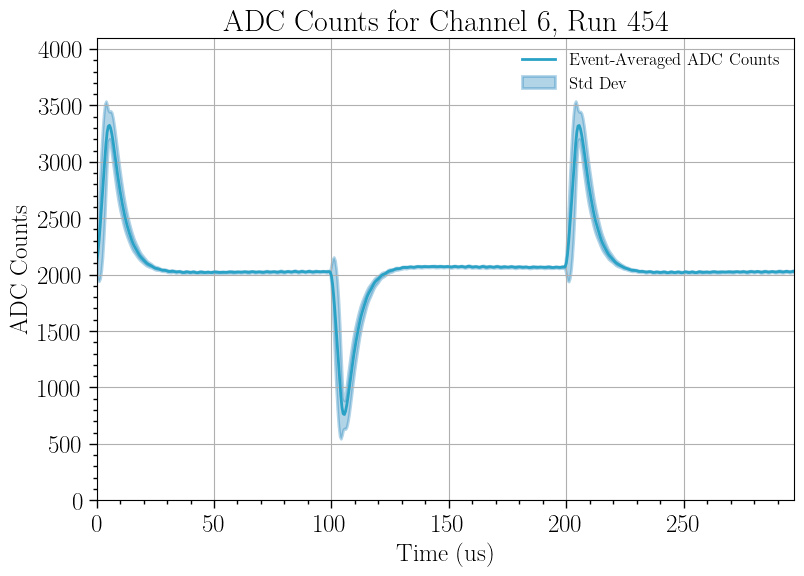

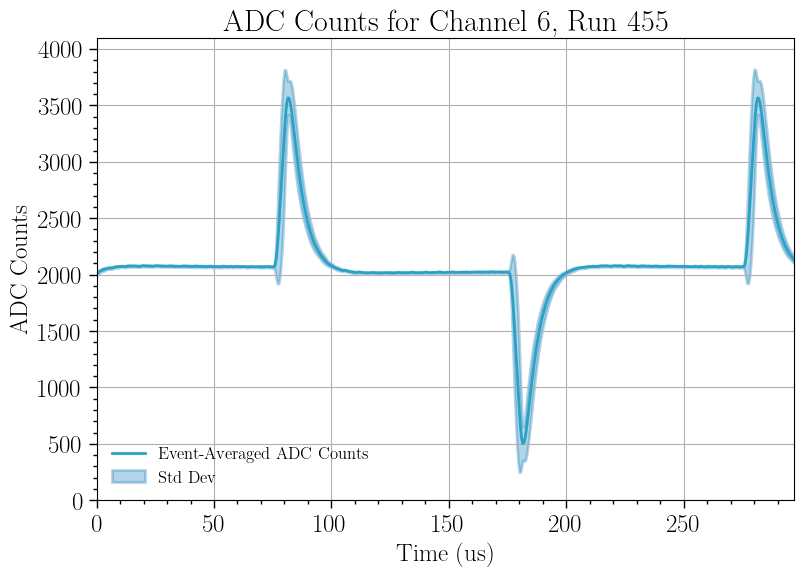

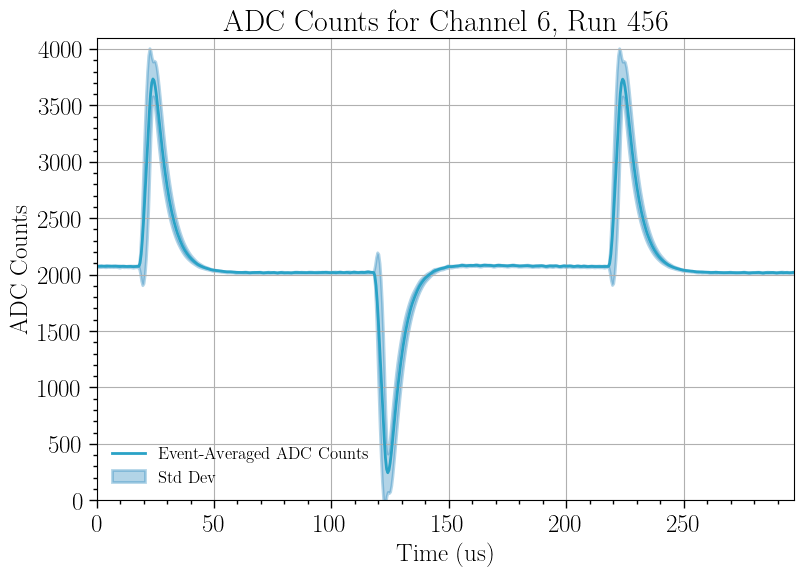

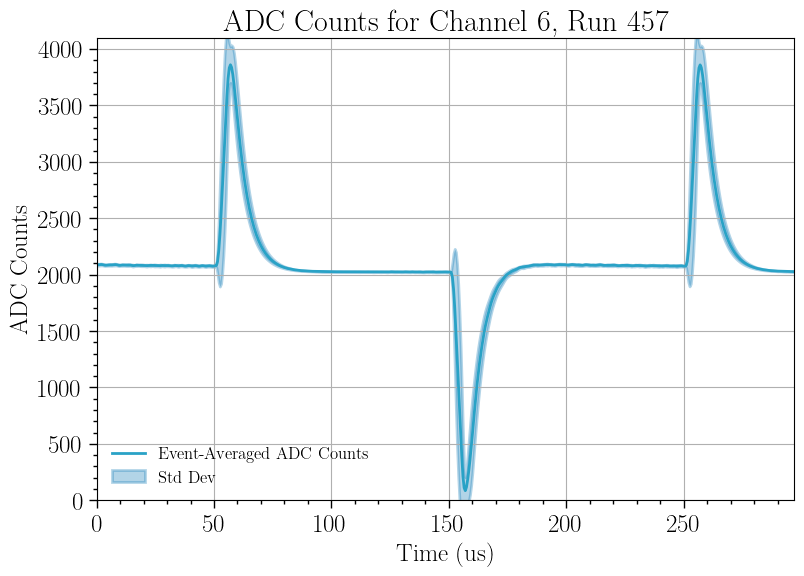

In [117]:
# set inputs, run plotter
file_list = [454, 455, 456, 457]
active_ch = 6

waveform_plotter(file_list, active_ch, overlay=0, average=0)

# ADC Calibration

In [37]:
def findpeaks(channels):
    peaks = dict()
    Q = dict()
    for ch in channels:
        # extract file_list and pulse heights for given channel
        mask_ch = csv[csv['ADC Ch.'].isin([ch])]
        file_list = mask_ch['File ID'].tolist()
        mV = mask_ch['Input (mVpp)'].tolist()
        
        # convert mV to charge
        Vdiv = (1/11) # preamp voltage divider
        Cin = 1 # preamp input capacitance, in pF
        Q[ch] = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC
        
        peaks[ch] = []
        for filename in file_list:
            df = df_dict[filename]

            # find FEM for run
            fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
            
            # slice dataframe for FEM and desired channel, find max height for each event
            mask = np.logical_and(df['fem_id'] == fem_id ,df['channel_id'] == ch)
            
            event_ids = np.unique(df['event_id'][mask])
            max_counts = []
            for event in event_ids:
                mask = df['event_id']==event
                max_counts = np.max(np.abs(df['adc_count'][mask] - 2048))+2048
            peaks[ch].append(max_counts.mean())
            
    return peaks, Q

## ADC Peaks vs. Input Charge Plotter

In [48]:
def plot_peaks_vs_Q(channels, overlay=1):
    peaks, Q = findpeaks(channels)
    # if overlay is enabled, plot on the same figure
    if overlay:
        figure = plt.figure(figsize=[9,6])
        [plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}') for c in channels]
        plt.title(f'ADC Amplitude vs. Input Charge')
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        plt.ylim(plt.ylim()[0], 4150)
        plt.grid(True)
        plt.legend(loc='best')
        plt.show()
    else:
        for c in channels:
            plt.figure(figsize=[9,6])
            plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}')
            plt.title(f'ADC Amplitude vs. Input Charge, Ch.{c}')
            plt.xlabel('Input Charge (fC)', fontsize=20)
            plt.ylabel('Counts')
            plt.ylim(plt.ylim()[0], 4150)
            plt.grid(True)
            plt.show()
            
    return

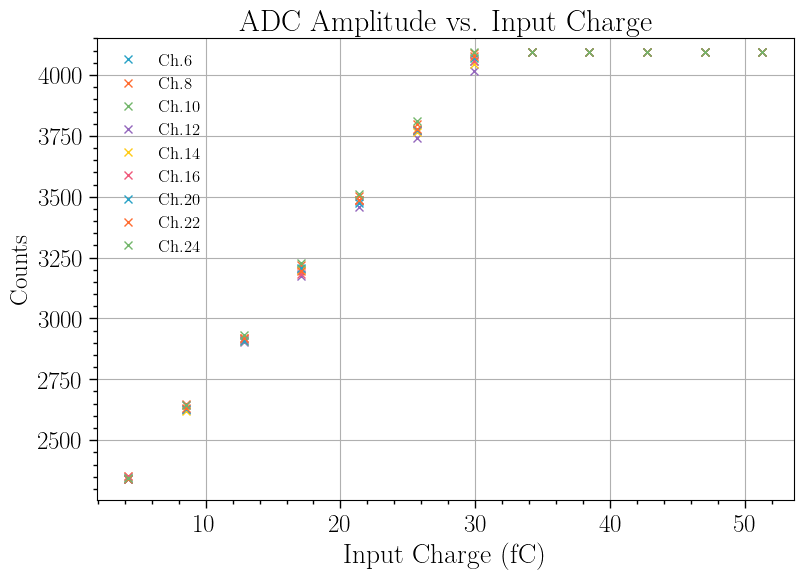

In [49]:
# set inputs and run function
channels = [6, 8, 10, 12, 14, 16, 20, 22, 24]
plot_peaks_vs_Q(channels, overlay=1)

## Linear Fit

In [45]:
def objective(params, x, y):
    m, b = params
    return np.sum((y - (m * x + b)) ** 2)

def linearity(channels, range=5):
    for c in channels:
        peaks, Q = findpeaks([c])
        peaksrange = np.array(peaks[c][:range])
        Qrange = np.array(Q[c][:range])

        guess = [1.0, 2048.0]
        
        # perform the minimization
        result = minimize(objective, guess, args=(Qrange, peaksrange))
        
        # results
        m, b = result.x
        
        # calculate and print calibration params
        res = m # counts/fC
        dyn_range = 4096*1/res # fC
        sat_point = (4095-b)/res # fC

        Vdiv = (1/11) # preamp voltage divider
        Cin = 1 # preamp input capacitance, in pF
        
        res_V = Vdiv*(m * 10**15)*(Cin * 10**-12)* 10**-3 # counts/mV
        dyn_range_V = 4096*1/res_V * 10**-3
        sat_point_V = (4095-b)/res_V
        
        print(f'Channel {c} Params (Charge):')
        print(f'Resolution: {res} counts/fC')
        print(f'Dynamic Range: {dyn_range} fC')
        print(f'Saturation Point: {sat_point} fC')
        print(f'Channel {c} Params (Volts):')
        print(f'Resolution: {res_V} counts/mV')
        print(f'Dynamic Range: {dyn_range_V} V')
        print(f'Saturation Point: {sat_point_V} mV')

        # plot
        plt.figure(figsize=[9,6])
        plt.plot(Q[c], peaks[c], marker='x', linestyle='None')
        x_range = np.linspace(0, sat_point, 100)
        plt.plot(x_range, (m*x_range + b), color=colors[0], alpha =0.3)
        plt.axhline(y=4095, color='r', alpha=0.5, linestyle='--', label='Saturation')
        plt.title(f'ADC Amplitude vs. Input Charge, Ch.{c}')
        plt.gca().set_xlim(left=0)
        plt.ylim(plt.ylim()[0], 4150)
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        plt.legend()
        plt.grid(True)
        plt.show()

Channel 6 Params (Charge):
Resolution: 66.53829787287077 counts/fC
Dynamic Range: 61.558532919280395 fC
Saturation Point: 30.567358422689942 fC
Channel 6 Params (Volts):
Resolution: 6.048936170260979 counts/mV
Dynamic Range: 0.6771438621120843 V
Saturation Point: 336.2409426495894 mV


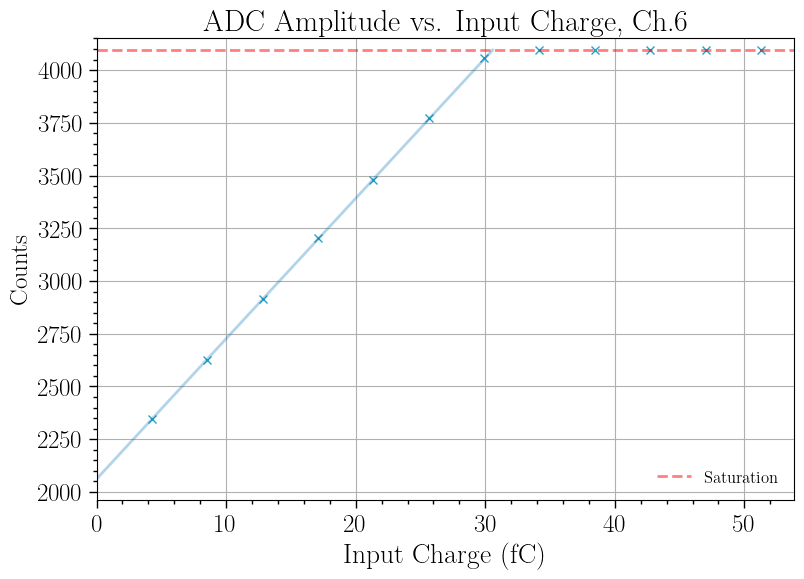

Channel 8 Params (Charge):
Resolution: 67.63829803862983 counts/fC
Dynamic Range: 60.55740784105298 fC
Saturation Point: 30.101289676181047 fC
Channel 8 Params (Volts):
Resolution: 6.148936185329984 counts/mV
Dynamic Range: 0.6661314862515827 V
Saturation Point: 331.1141864379915 mV


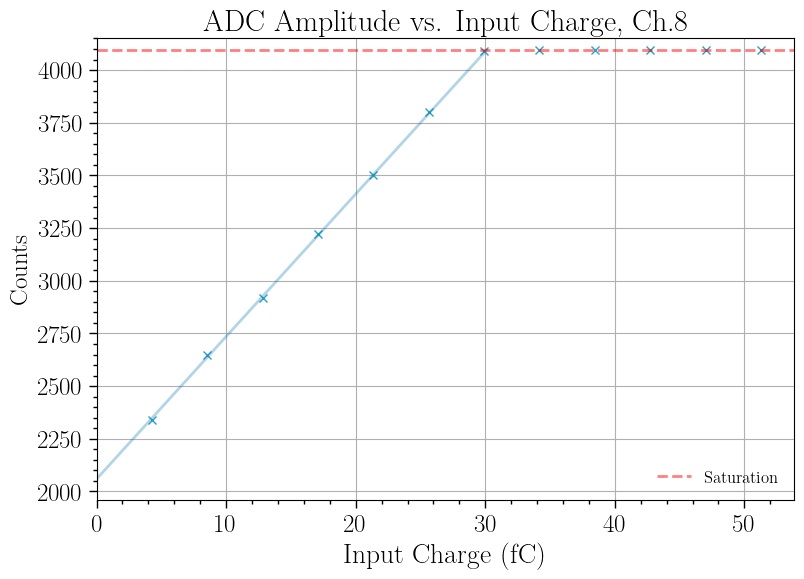

Channel 12 Params (Charge):
Resolution: 65.04042568868314 counts/fC
Dynamic Range: 62.97621758513018 fC
Saturation Point: 31.194445309007783 fC
Channel 12 Params (Volts):
Resolution: 5.912765971698469 counts/mV
Dynamic Range: 0.6927383934364318 V
Saturation Point: 343.1388983990855 mV


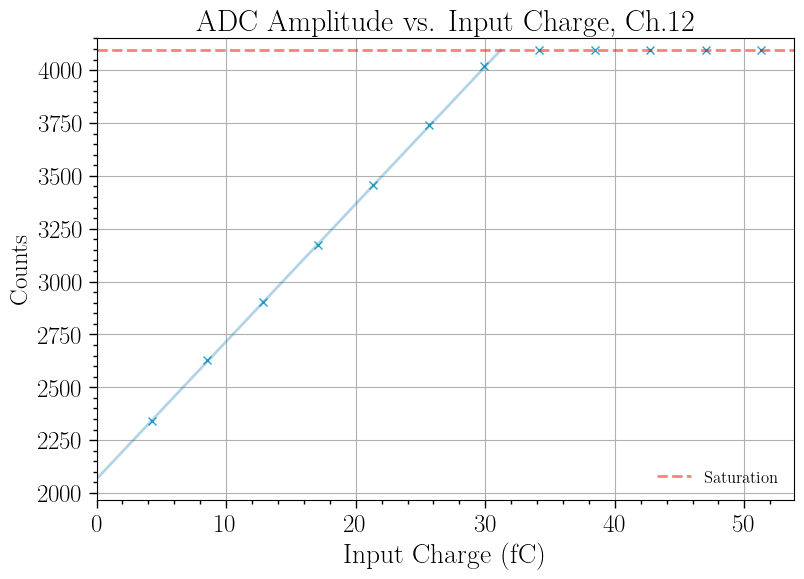

Channel 14 Params (Charge):
Resolution: 66.70212752827041 counts/fC
Dynamic Range: 61.40733664400719 fC
Saturation Point: 30.541754419205333 fC
Channel 14 Params (Volts):
Resolution: 6.063829775297309 counts/mV
Dynamic Range: 0.6754807030840791 V
Saturation Point: 335.9592986112587 mV


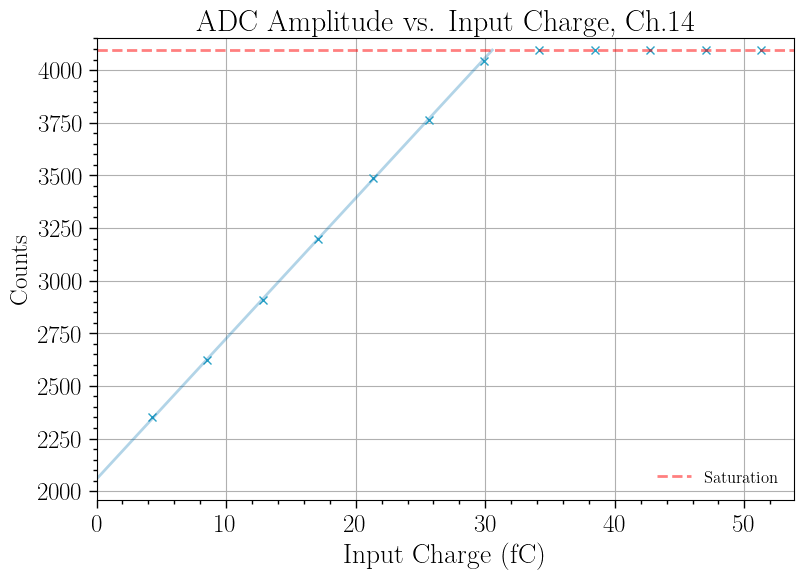

Channel 16 Params (Charge):
Resolution: 65.76595747866045 counts/fC
Dynamic Range: 62.28146227976774 fC
Saturation Point: 30.748430916064542 fC
Channel 16 Params (Volts):
Resolution: 5.978723407150952 counts/mV
Dynamic Range: 0.685096085077445 V
Saturation Point: 338.2327400767099 mV


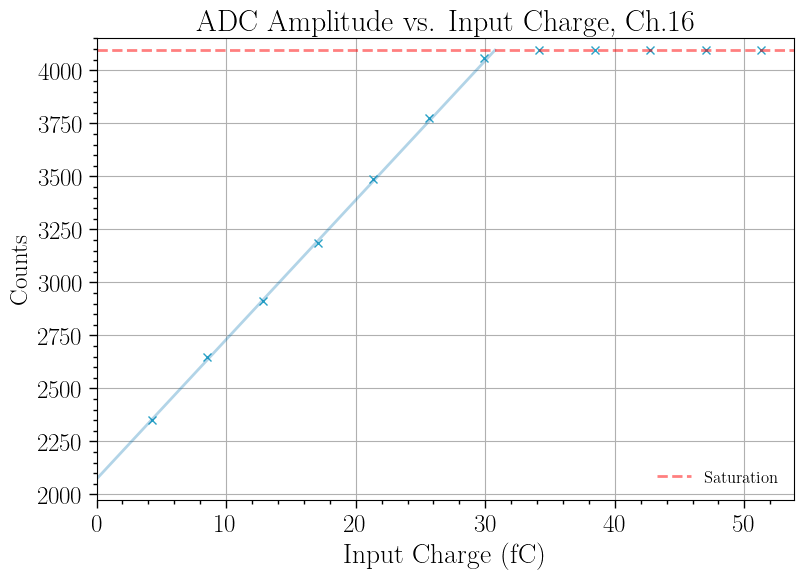

Channel 20 Params (Charge):
Resolution: 66.63191362598694 counts/fC
Dynamic Range: 61.47204510726418 fC
Saturation Point: 30.581441725881632 fC
Channel 20 Params (Volts):
Resolution: 6.057446693271539 counts/mV
Dynamic Range: 0.6761924961799061 V
Saturation Point: 336.39585898469795 mV


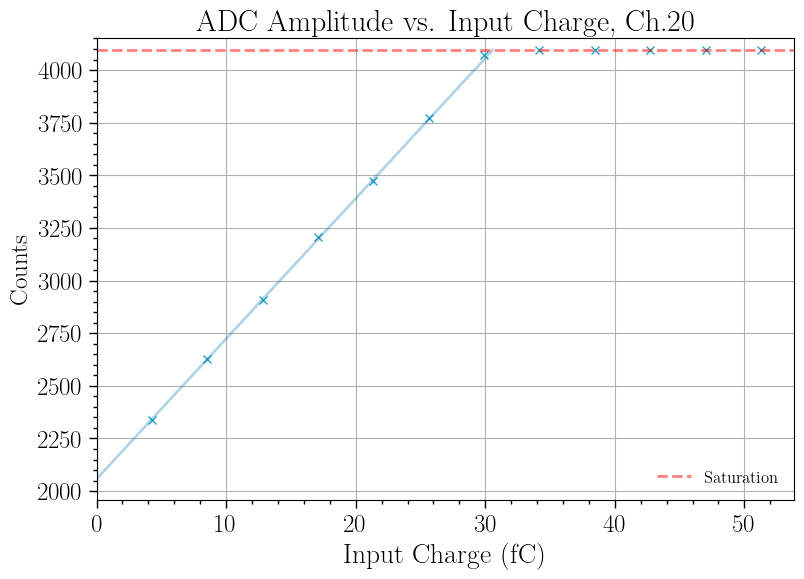

Channel 22 Params (Charge):
Resolution: 66.77234079068226 counts/fC
Dynamic Range: 61.34276485588739 fC
Saturation Point: 30.484179235422662 fC
Channel 22 Params (Volts):
Resolution: 6.070212799152934 counts/mV
Dynamic Range: 0.6747704134147613 V
Saturation Point: 335.32597158964927 mV


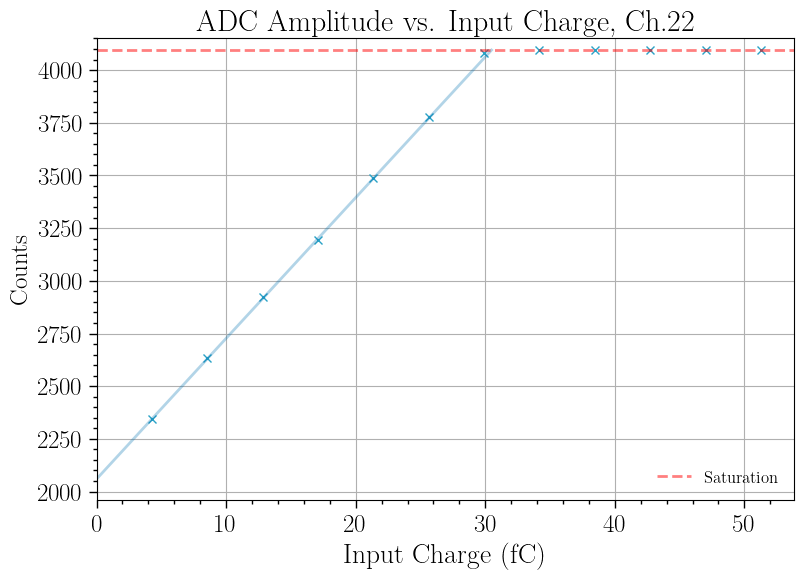

Channel 24 Params (Charge):
Resolution: 68.15319132230232 counts/fC
Dynamic Range: 60.09990024721898 fC
Saturation Point: 29.891483559994363 fC
Channel 24 Params (Volts):
Resolution: 6.195744665663847 counts/mV
Dynamic Range: 0.661098902719409 V
Saturation Point: 328.80631915993797 mV


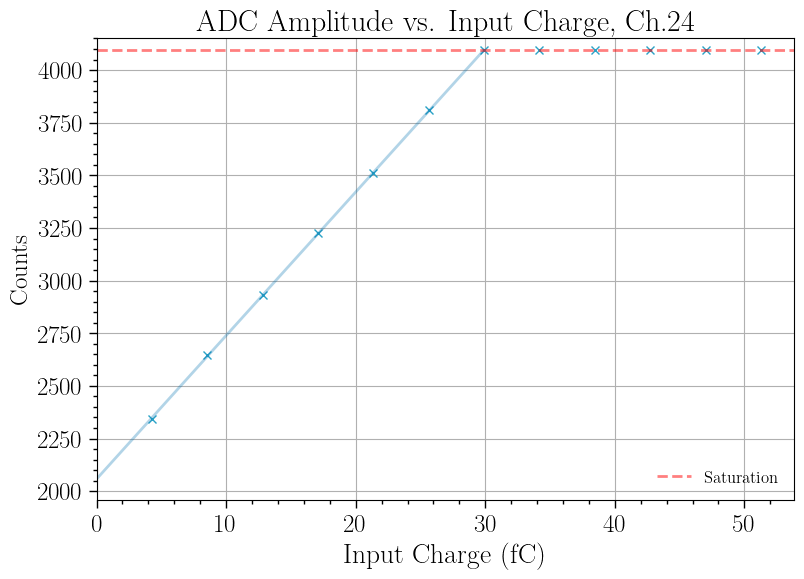

In [50]:
channels = [6, 8, 12, 14, 16, 20, 22, 24]
linearity(channels)

# Noise

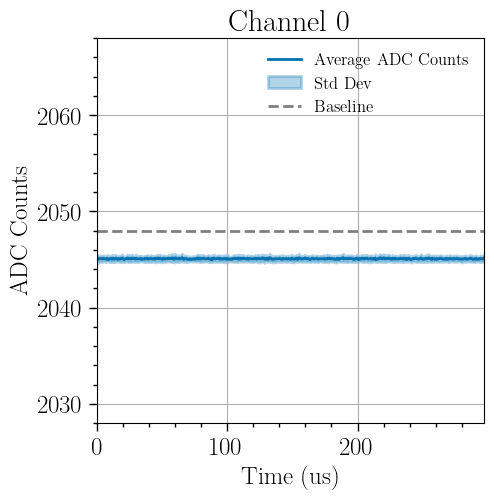

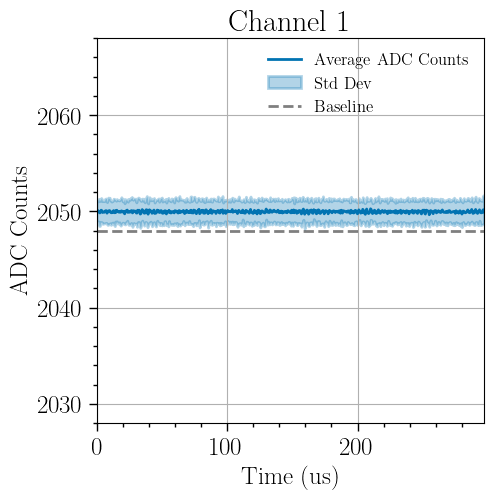

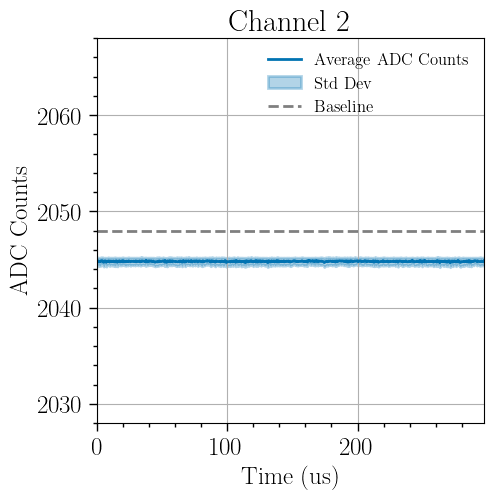

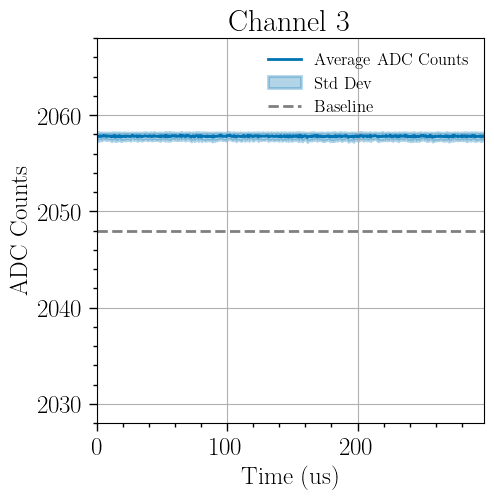

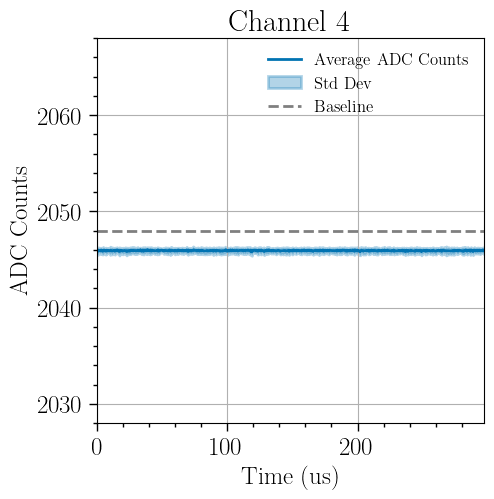

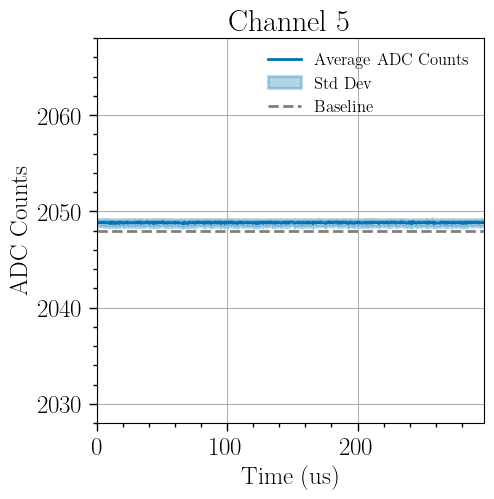

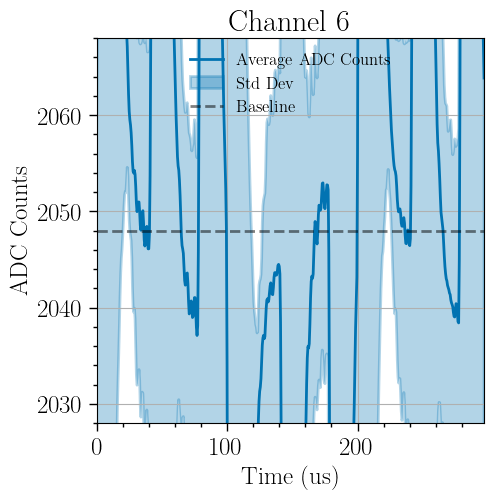

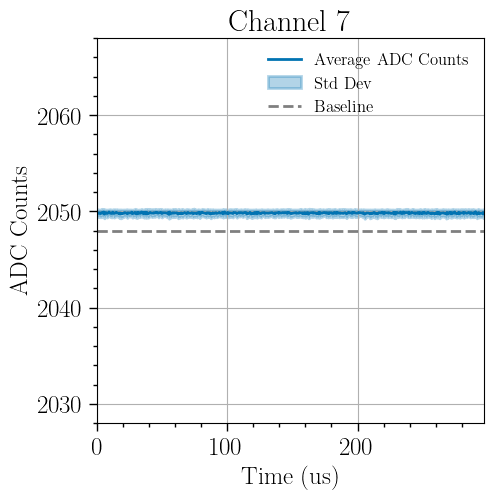

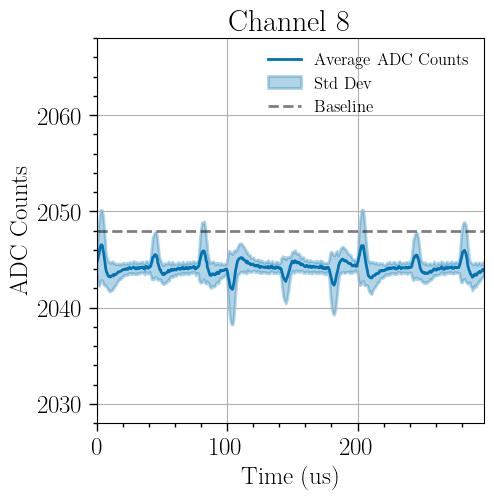

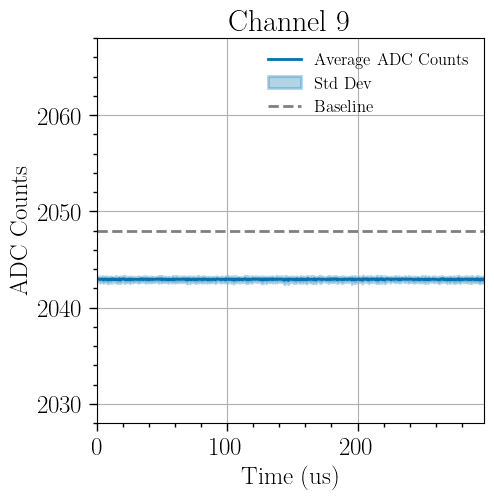

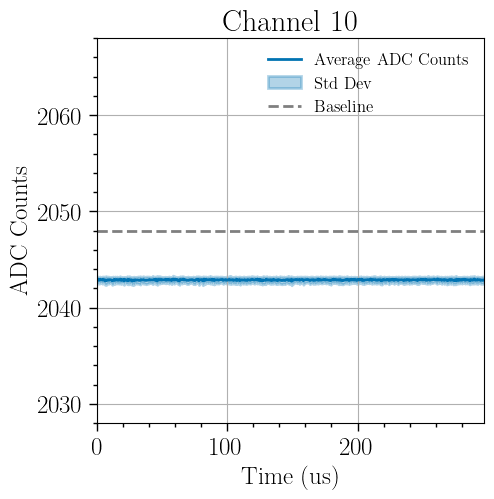

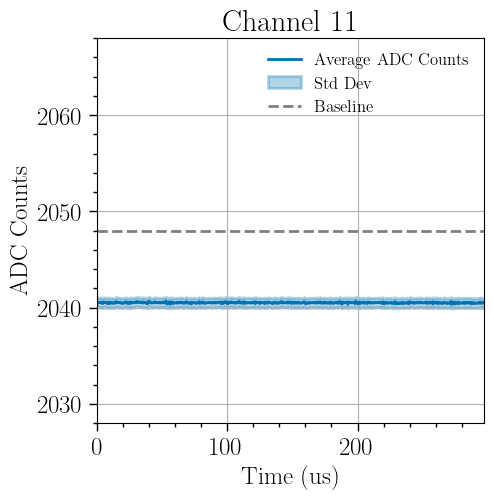

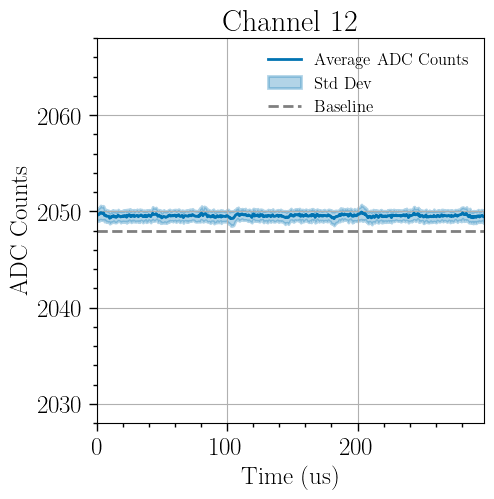

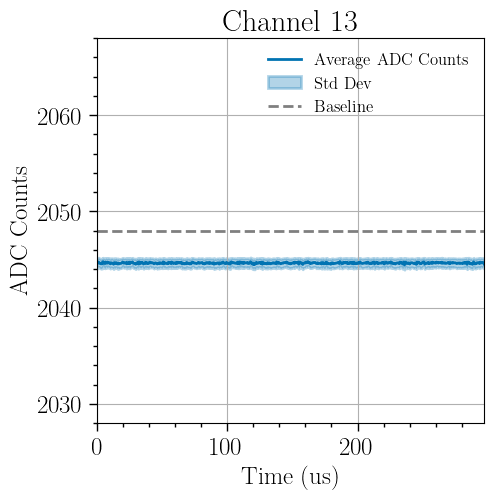

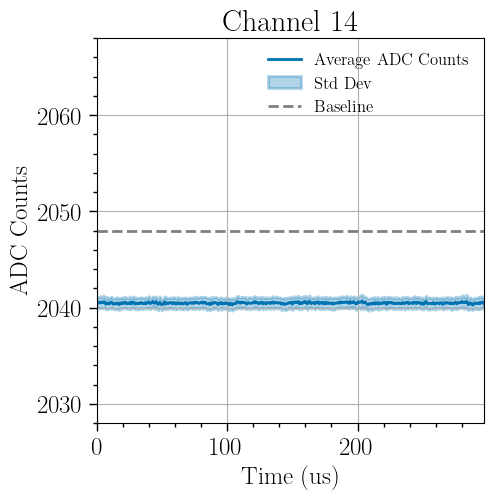

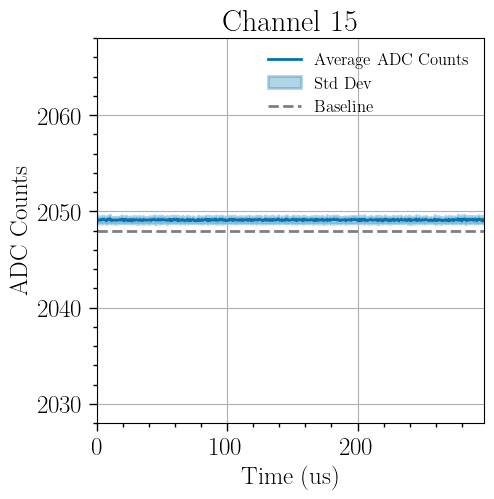

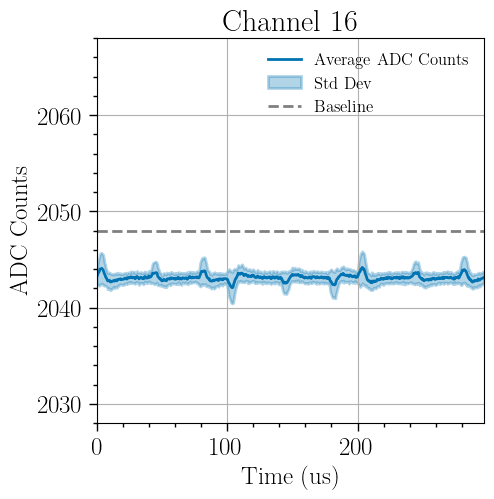

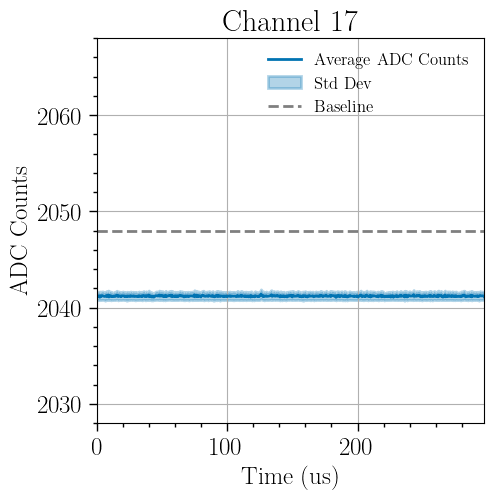

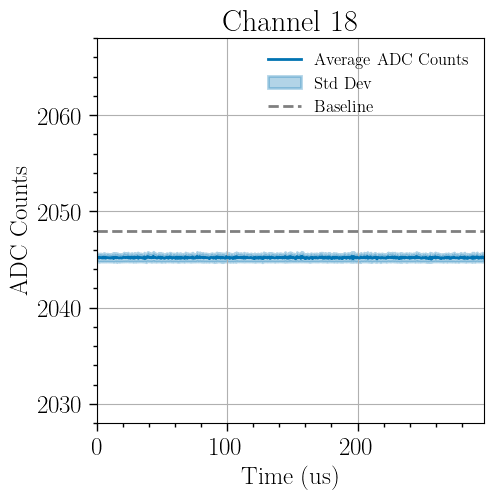

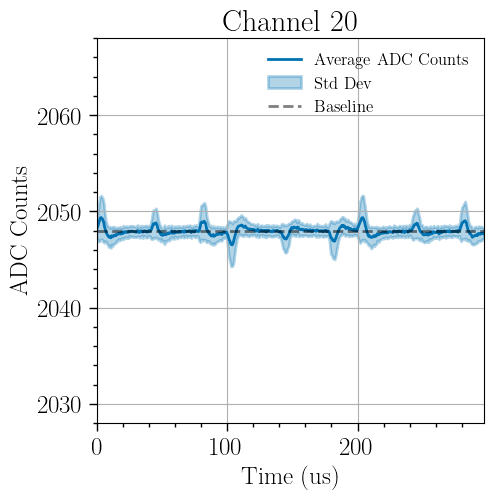

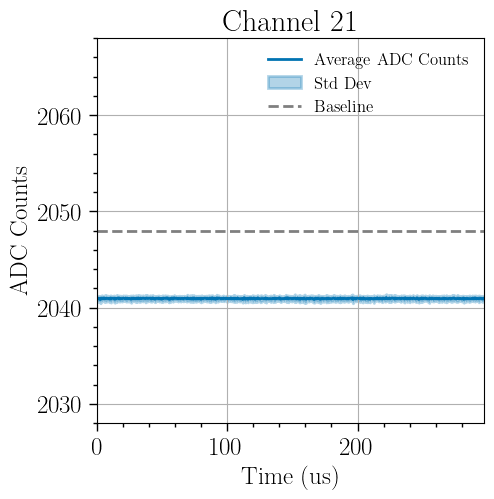

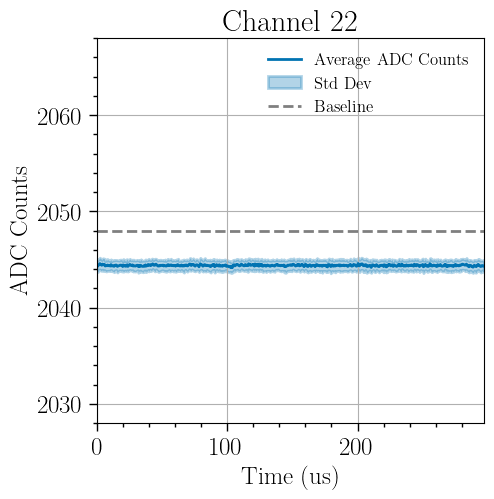

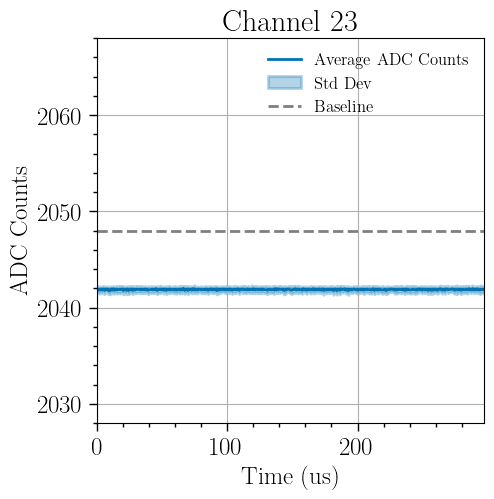

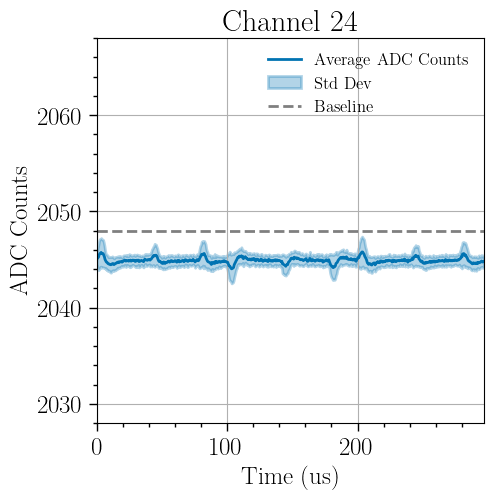

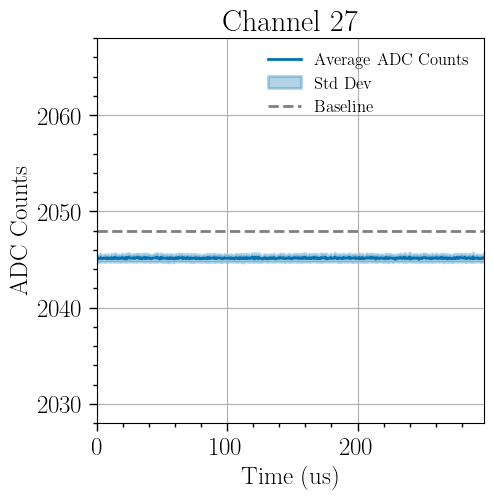

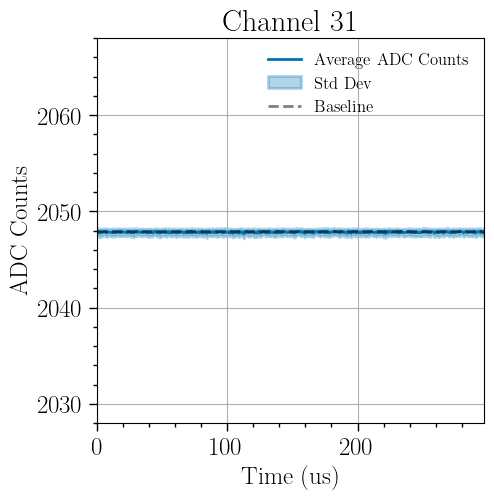

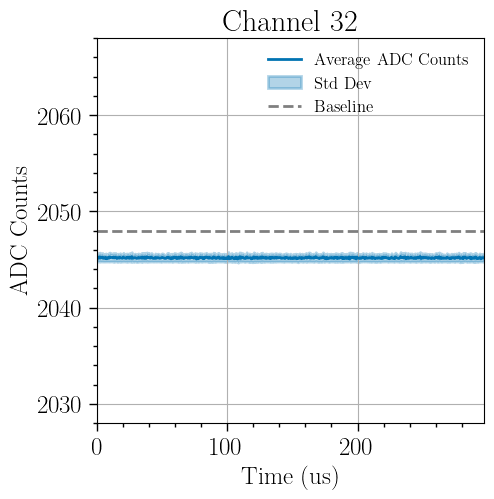

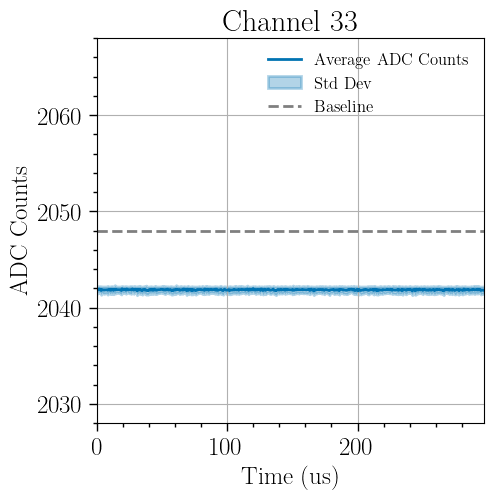

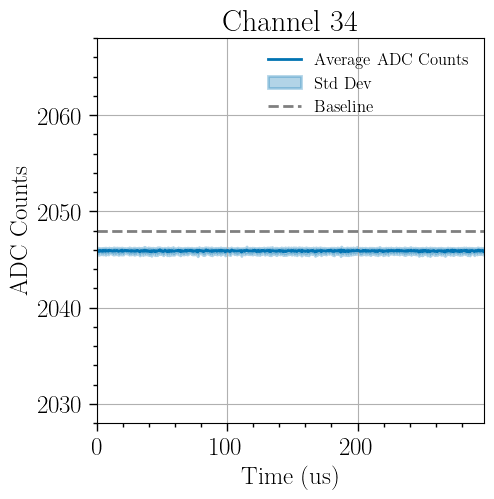

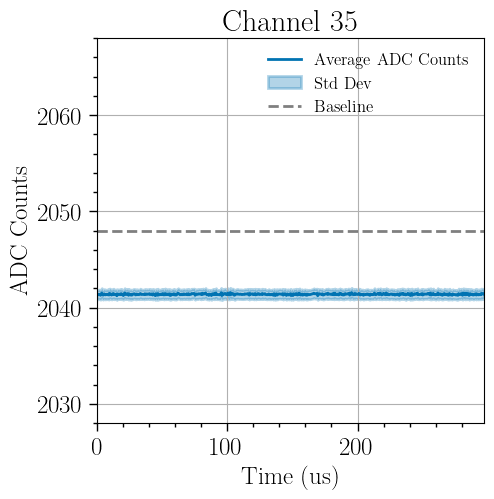

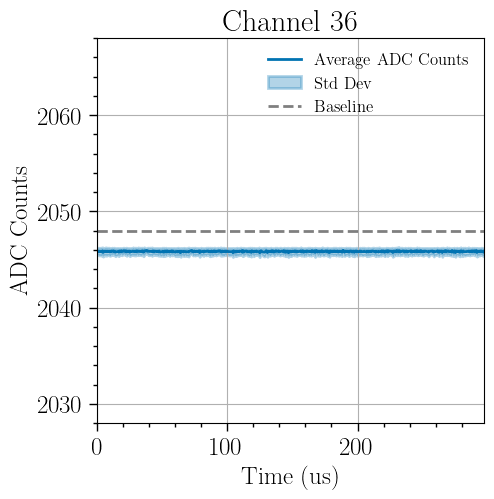

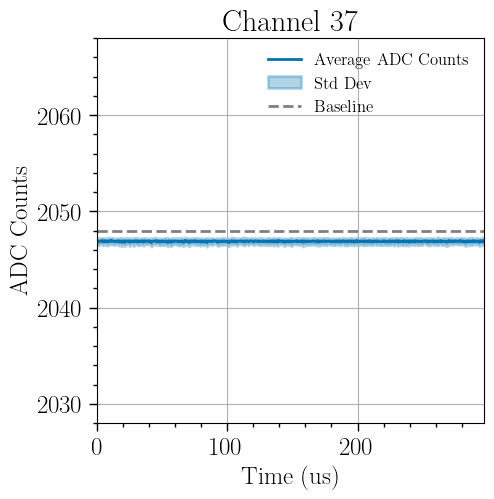

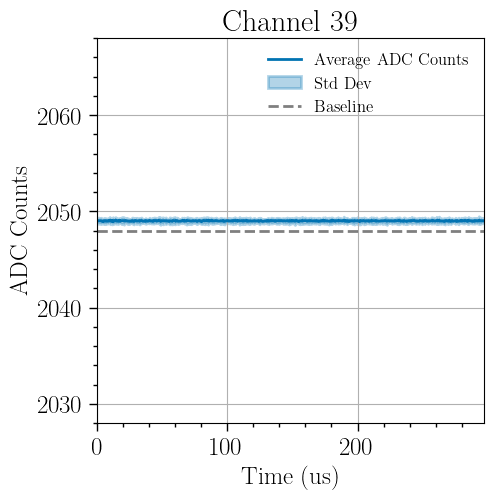

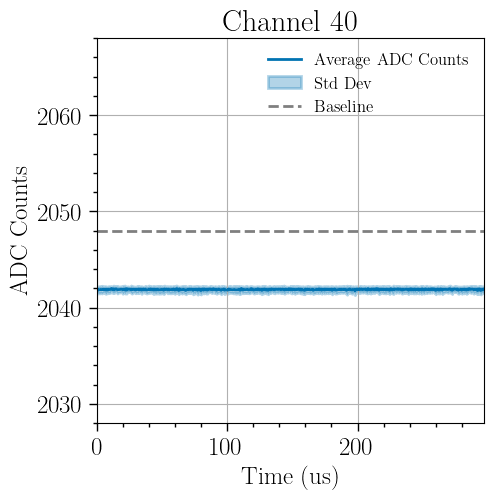

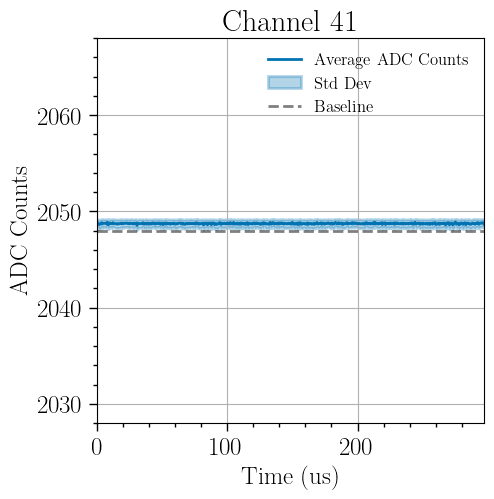

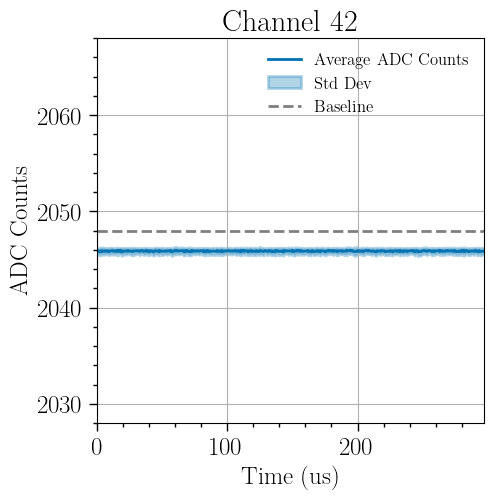

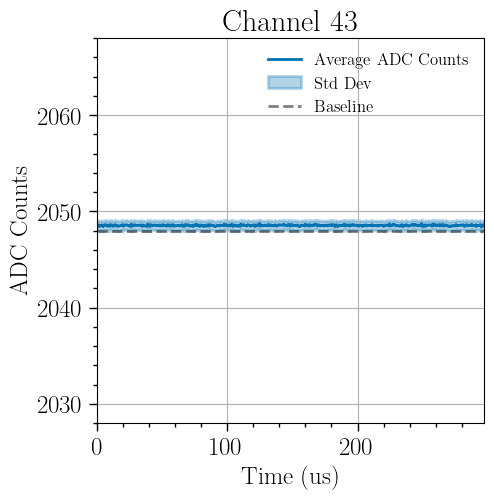

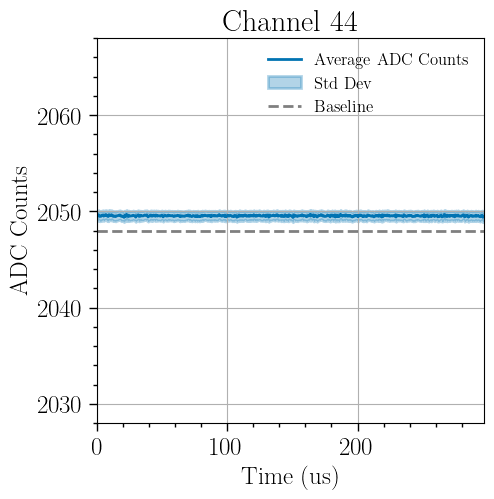

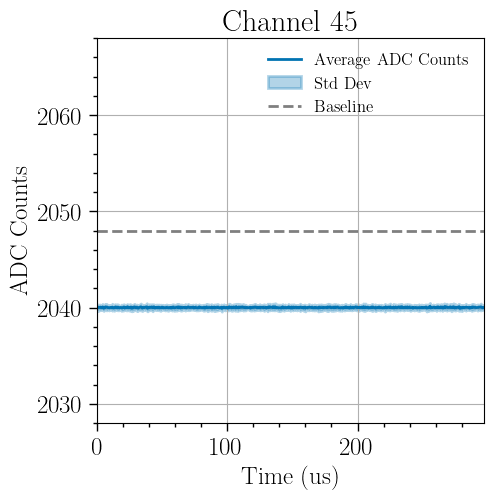

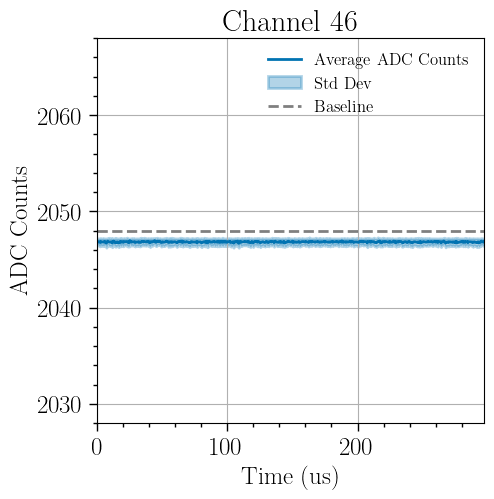

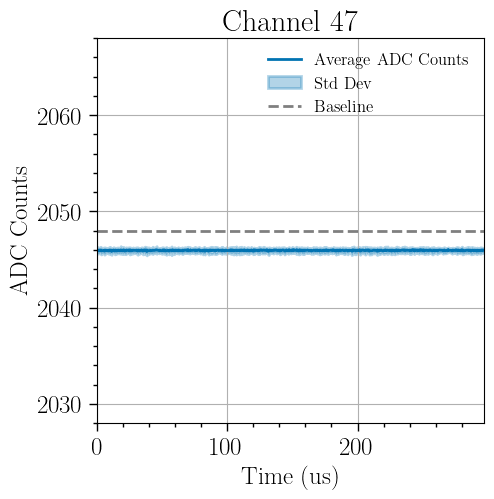

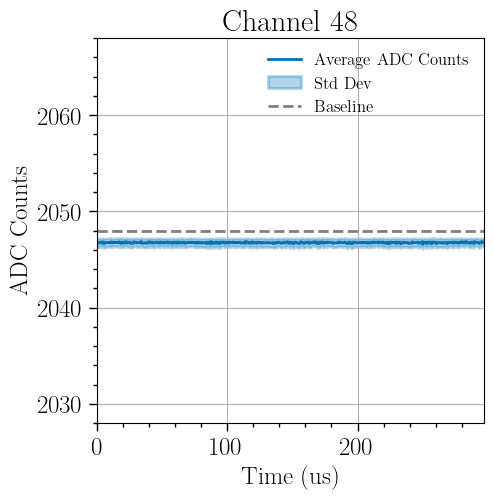

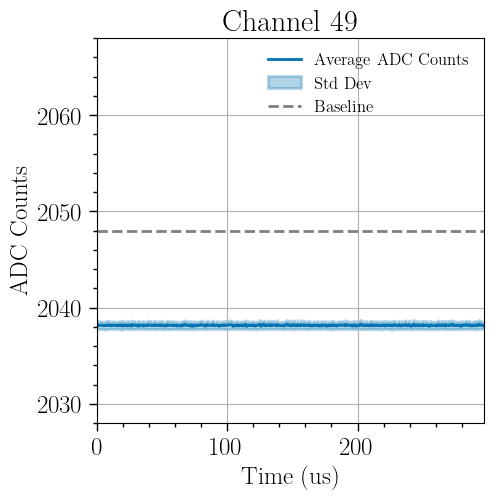

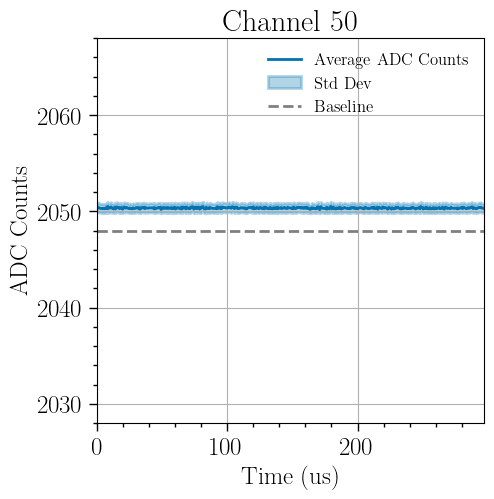

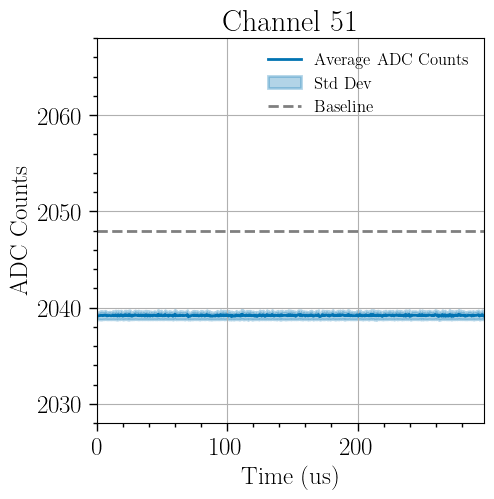

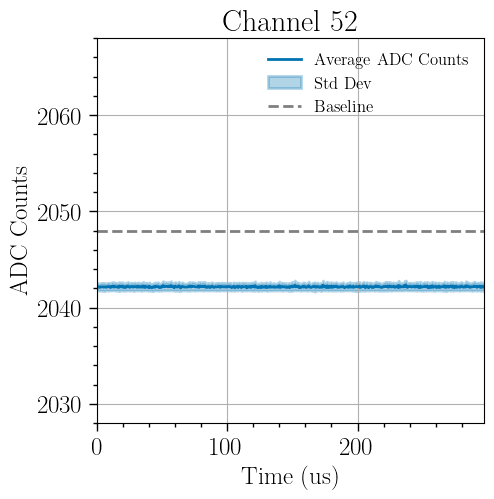

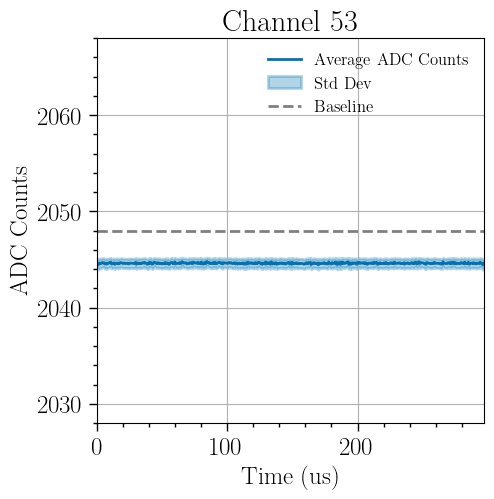

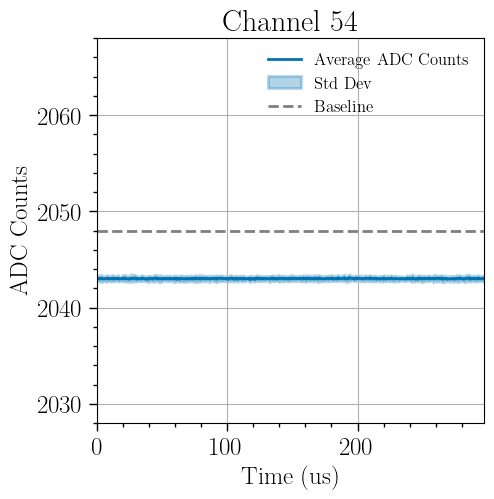

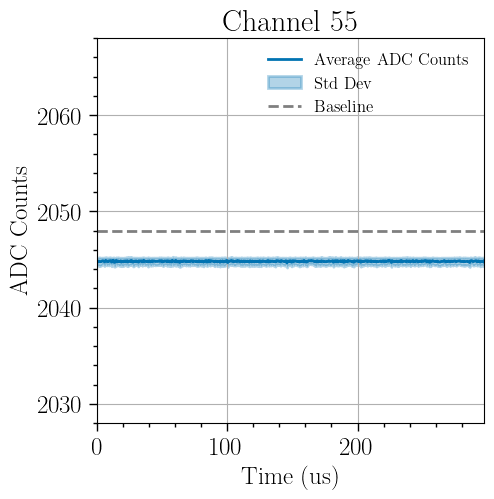

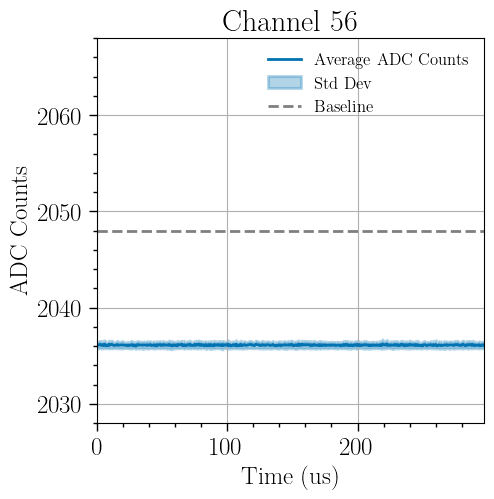

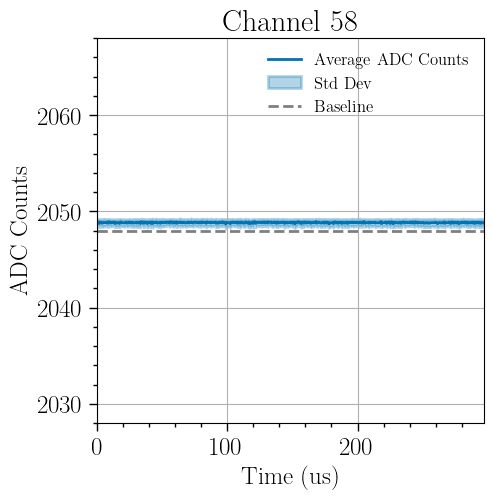

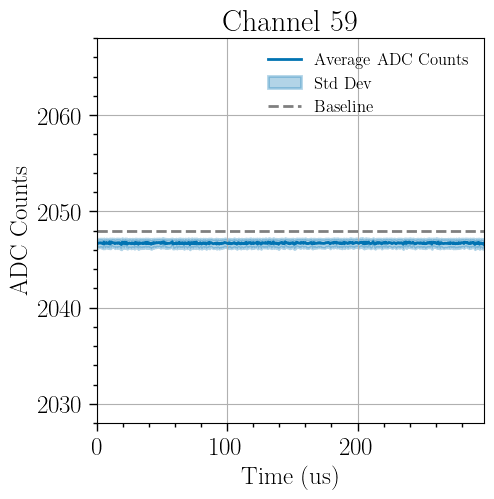

Ch: 63 Event: 25 FEM: 14 Found missing adc counts. 548 instead of 595
Ch: 63 Event: 25 FEM: 14 Found missing adc counts. 548 instead of 595
Ch: 63 Event: 25 FEM: 14 Found missing adc counts. 548 instead of 595


ValueError: x and y must have same first dimension, but have shapes (548,) and (595,)

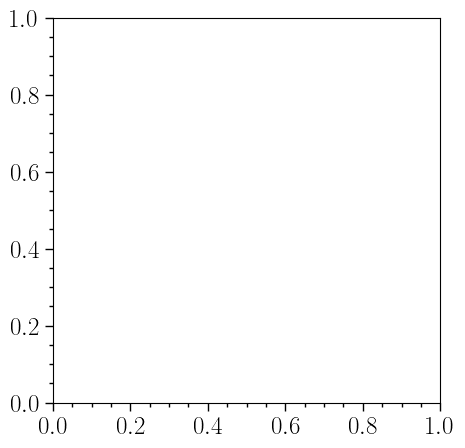

In [47]:
# grab files with zero input pulse
# mask_ch = csv[csv['Input (mVpp)'].isin([0])] 
# file_list = mask_ch['File ID'].tolist()

# plot baselines
channels=np.arange(0, 64, 1)
for ch in channels:
    waveform_plotter(file_list, ch, average=1, zoom=1)

In [ ]:
#Get noise counts for all channels (except for active one) for noise measurements

def noise_counts(file_list, active_ch):
#inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 

    counts = dict()
    nloops = 0
    #Loop over files
    for filename in file_list:
        df = df_dict[filename]
        # find FEM ID for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # filter data by FEM and desired channel
        fem_mask = df['fem_id']==fem_id

        #get all event ids in file
        all_evs = np.unique(df['event_id'])
        
        #remove any active channel if passed
        all_chs = np.unique(df['channel_id'])
        non_active = np.delete(all_chs, np.where(all_chs==active_ch)[0][0])

        #loop over channels
        for ch in non_active:
            counts[ch] = []
            nloops+=1
            #loop over events
            for ev in all_evs:
                mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==ev, df['channel_id']==ch))
                adc_counts = df['adc_count'][mask]
                if nloops<2:
                    nsamps = len(adc_counts)
                if(len(adc_counts)!=nsamps):
                    print('Skipping Ch: {} Event: {}. Found {} missing samples'.format(ch, ev, abs(len(adc_counts)-nsamps)))
                else:
                    counts[ch].append(adc_counts)
                    #sum_squares.append(adc_counts ** 2)
        
        channels = [key for key in counts.keys()]
        counts = {ch: np.concatenate(counts[ch]) for ch in channels}

    return counts

In [ ]:
counts = noise_counts(file_list, active_ch)

In [29]:
# Plot noise histogram for every channel

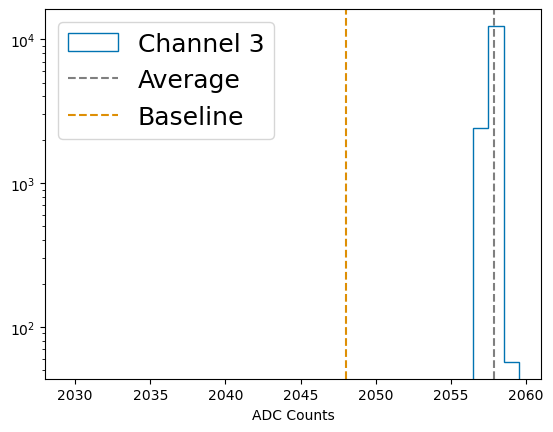

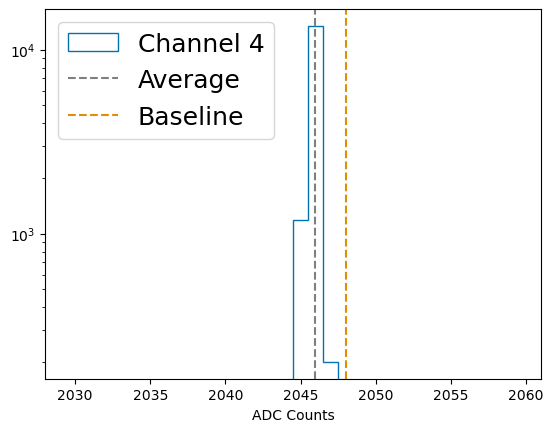

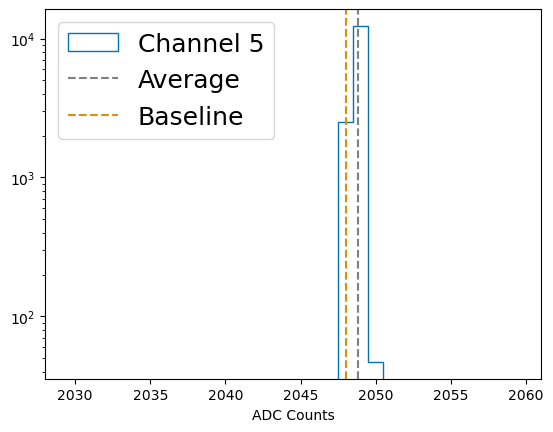

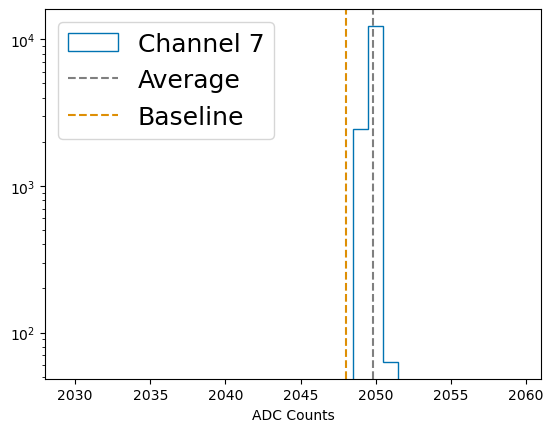

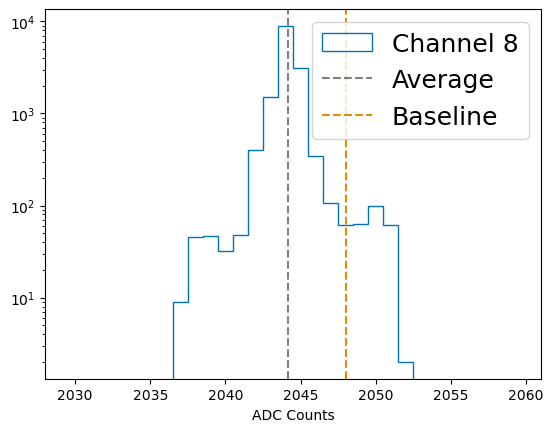

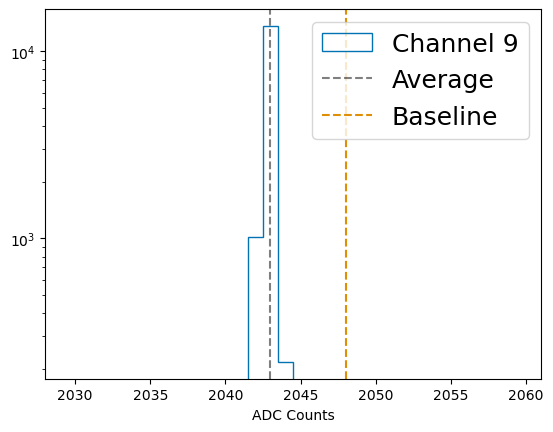

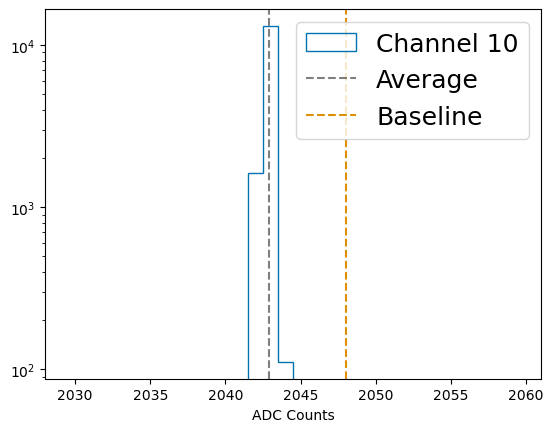

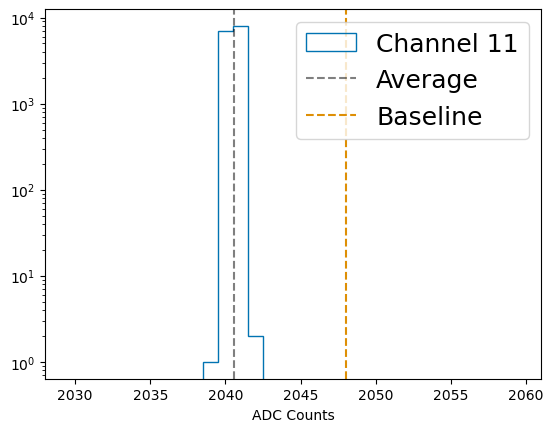

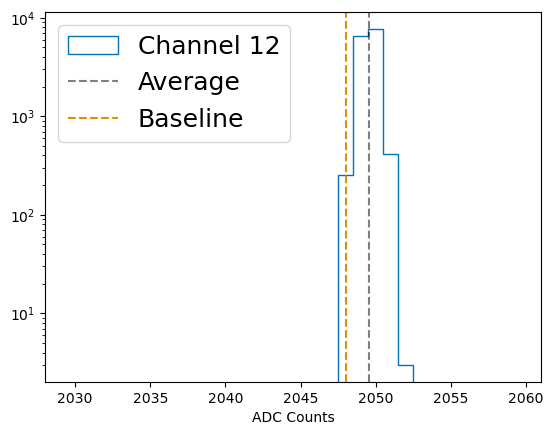

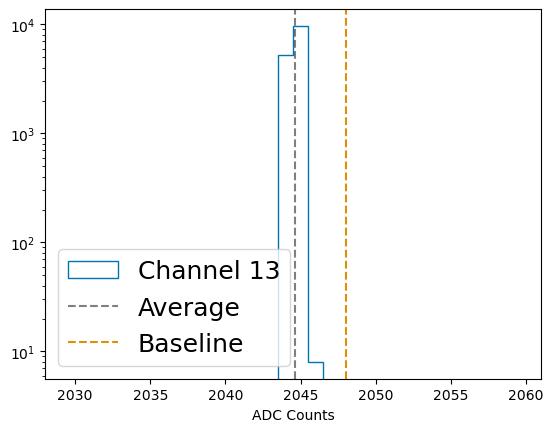

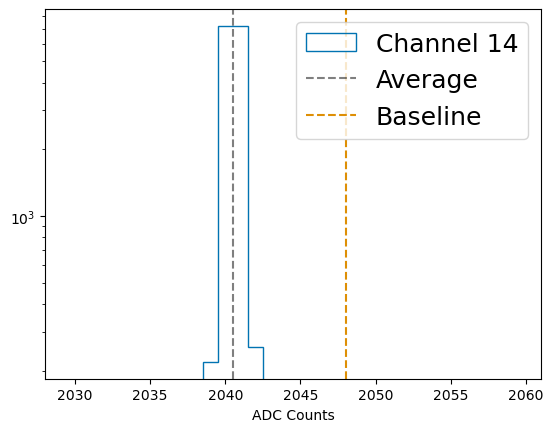

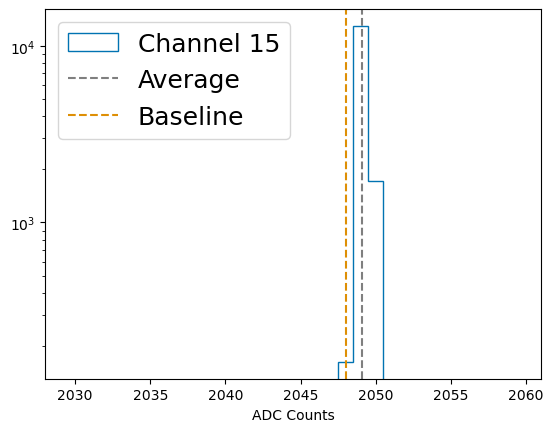

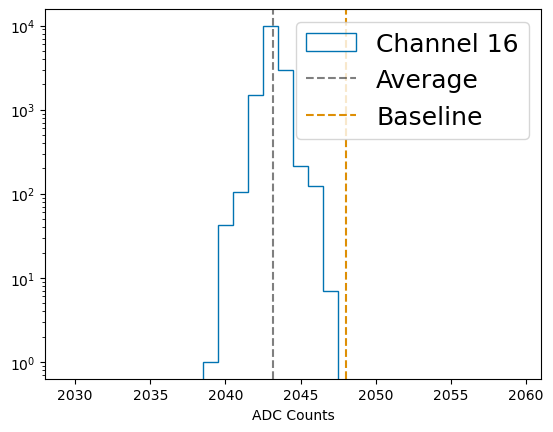

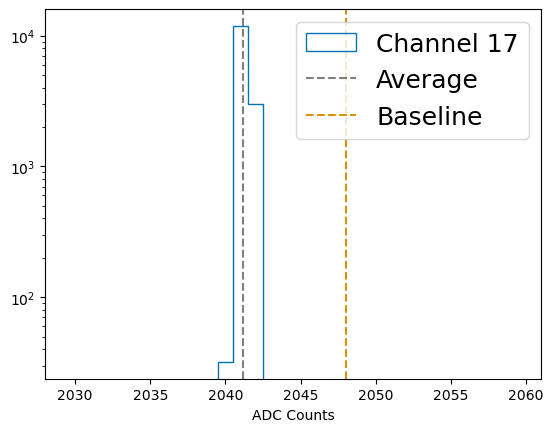

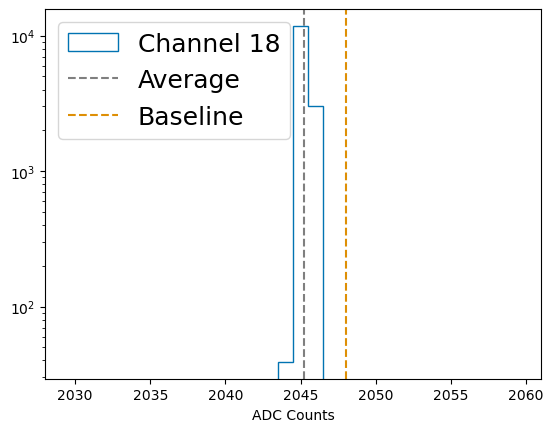

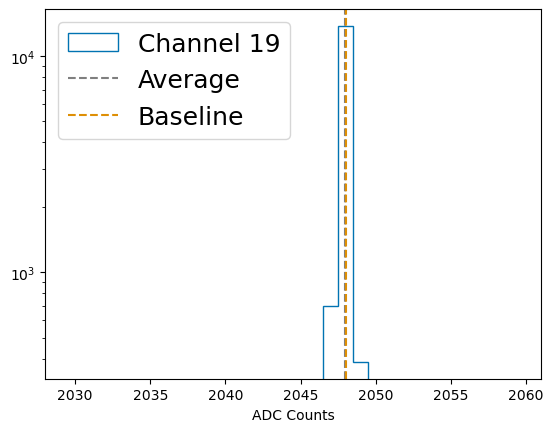

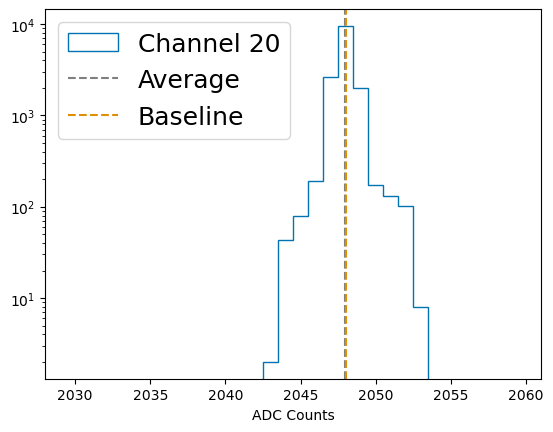

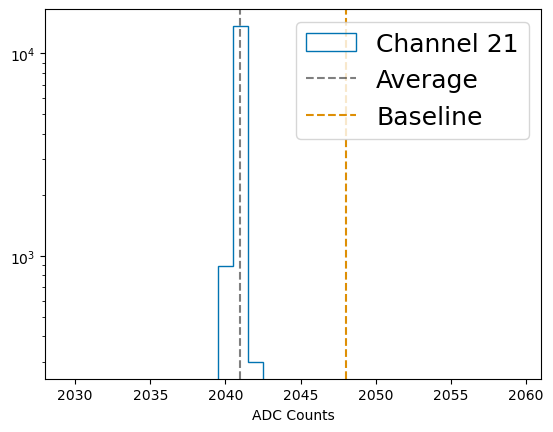

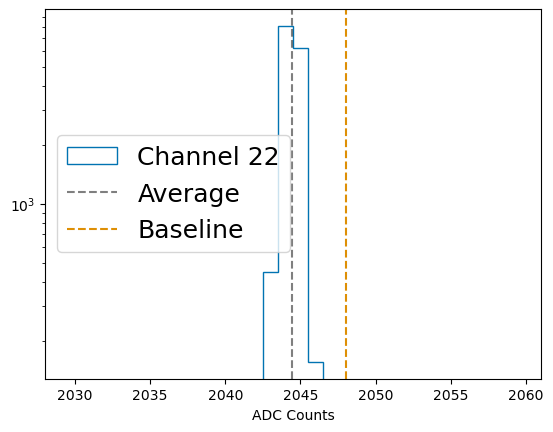

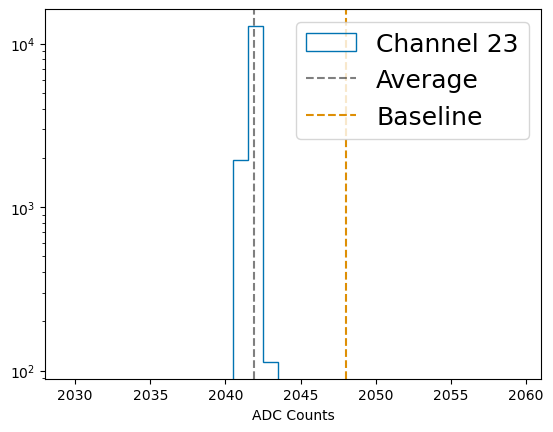

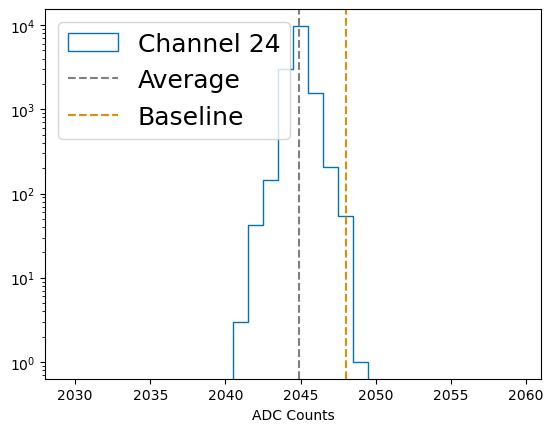

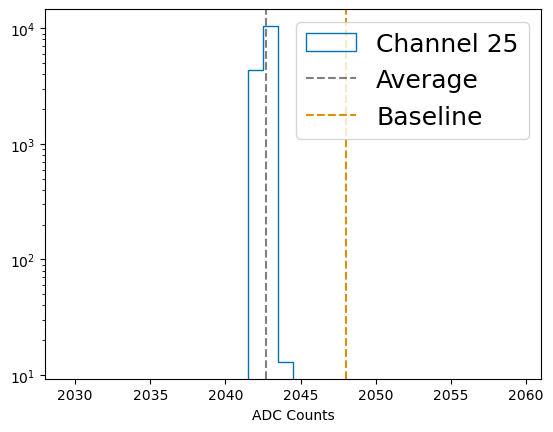

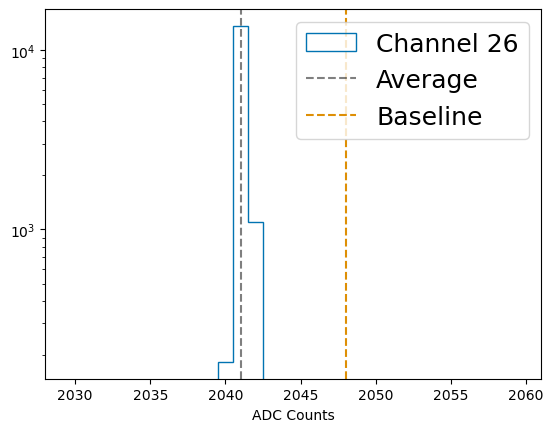

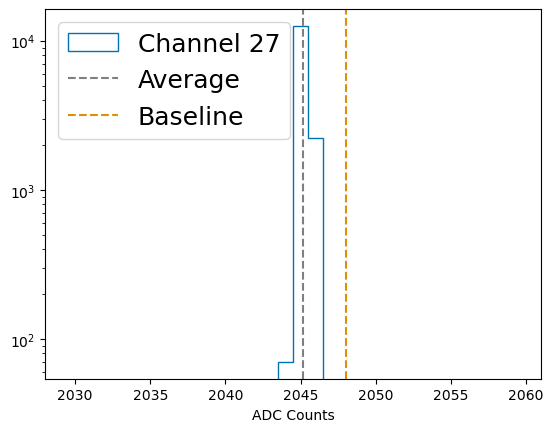

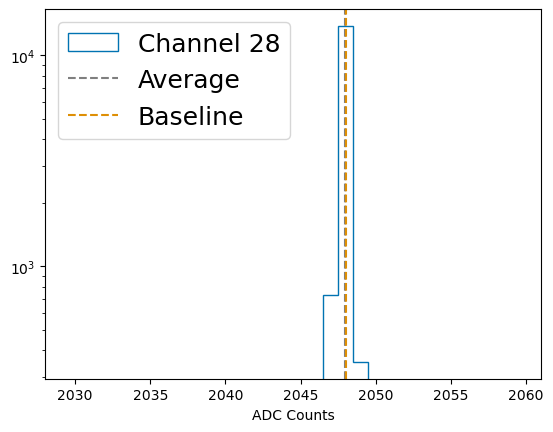

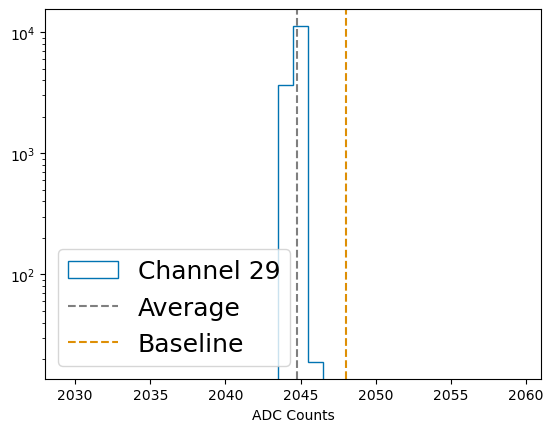

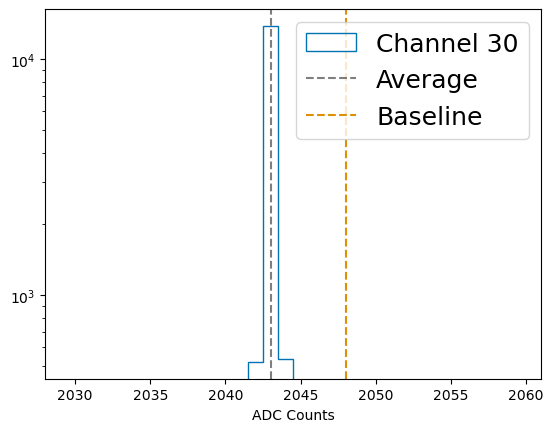

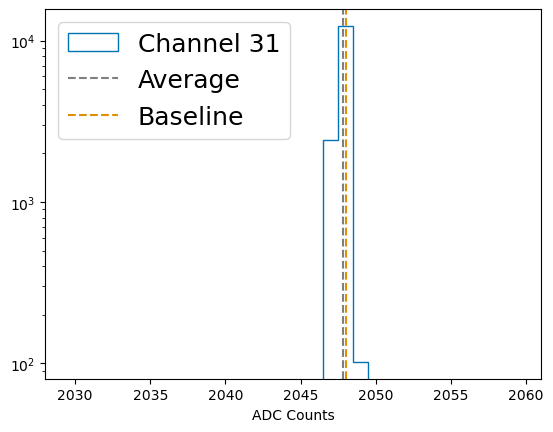

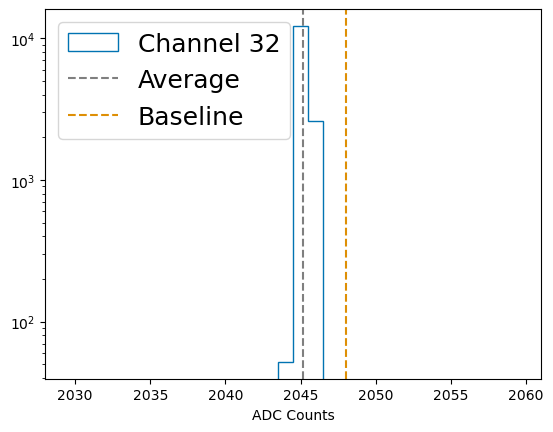

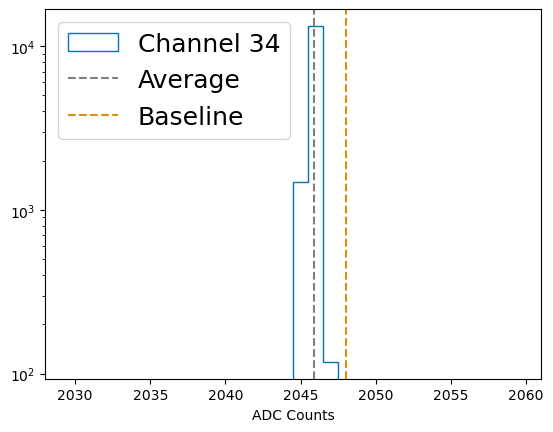

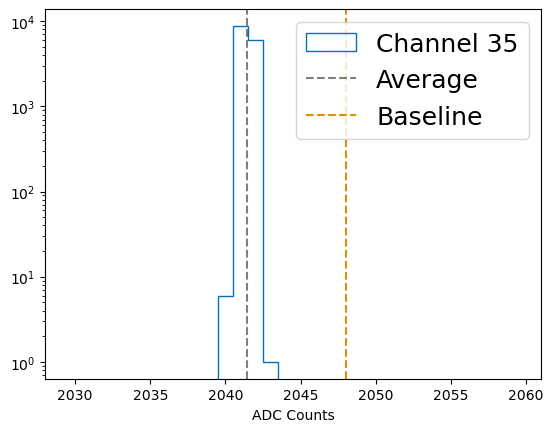

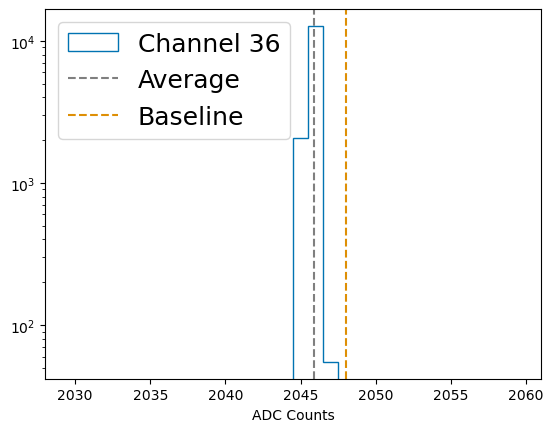

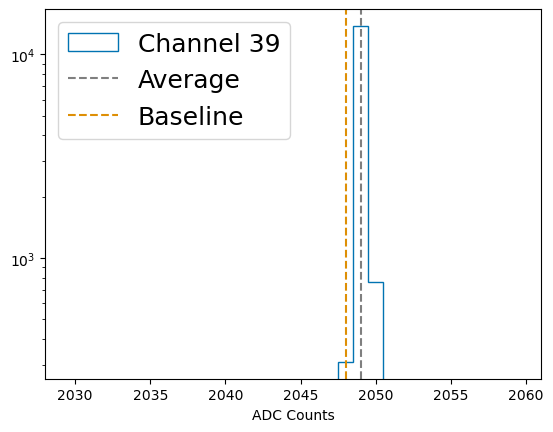

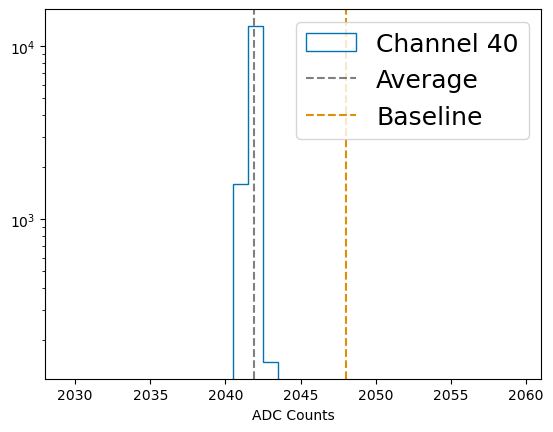

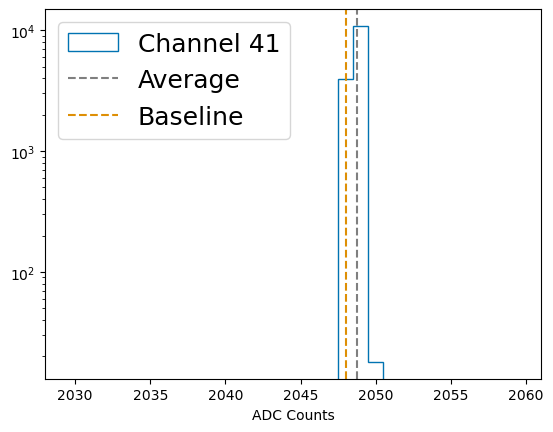

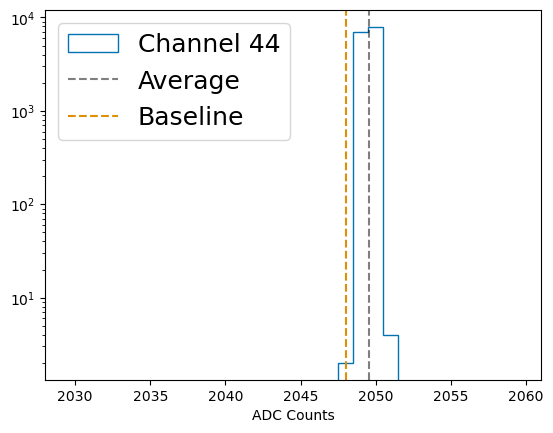

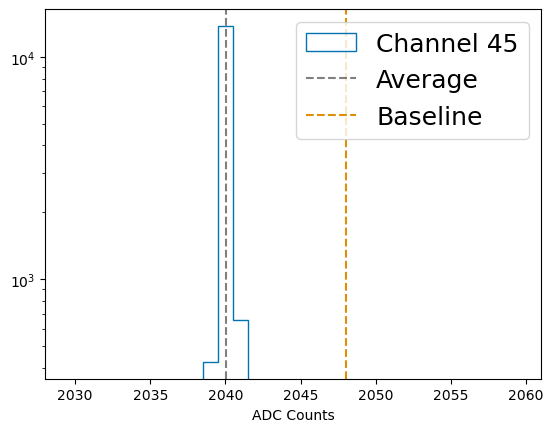

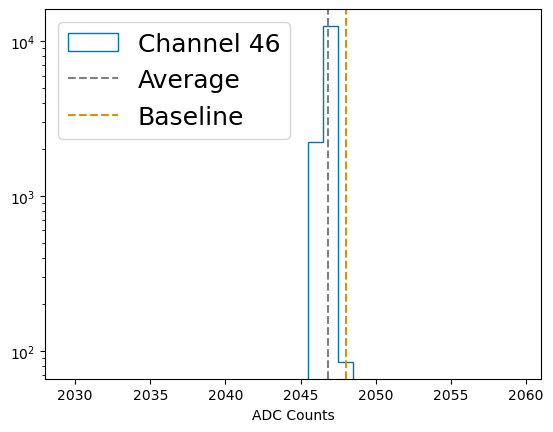

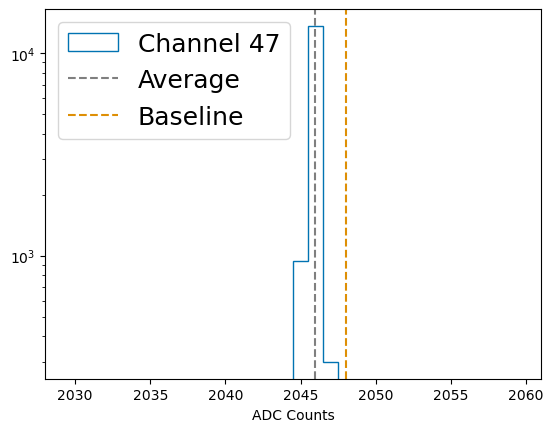

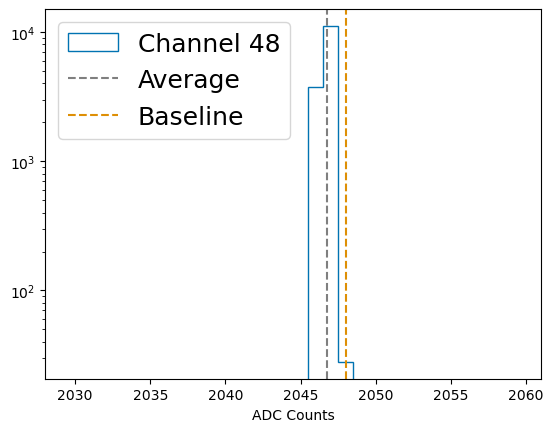

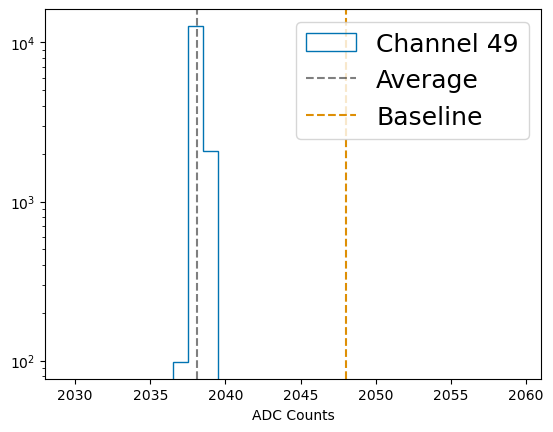

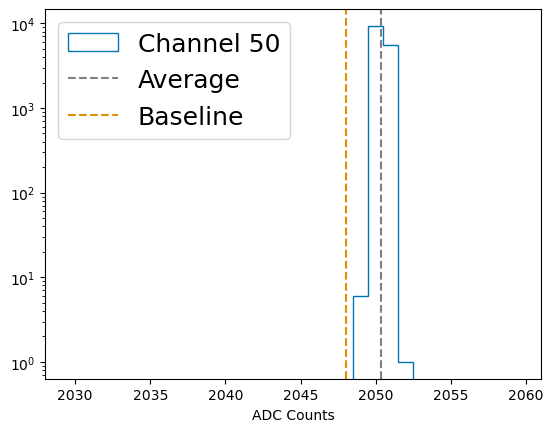

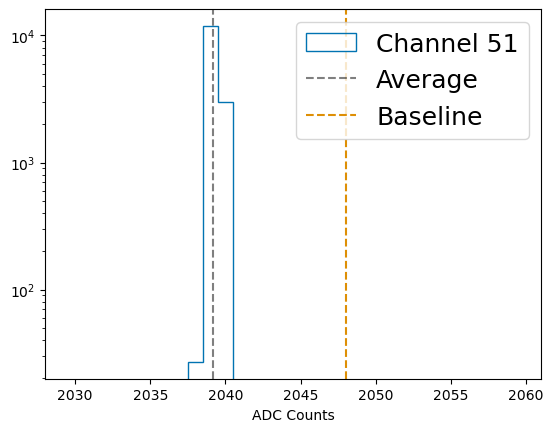

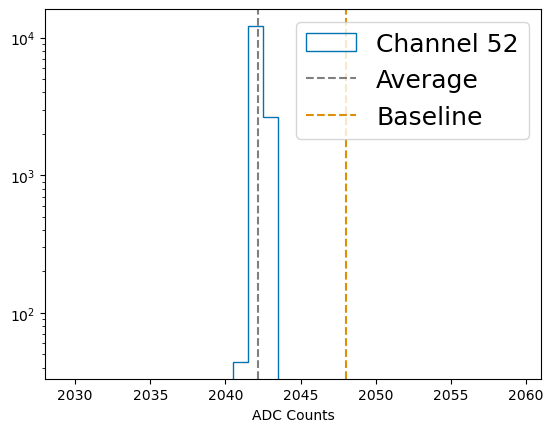

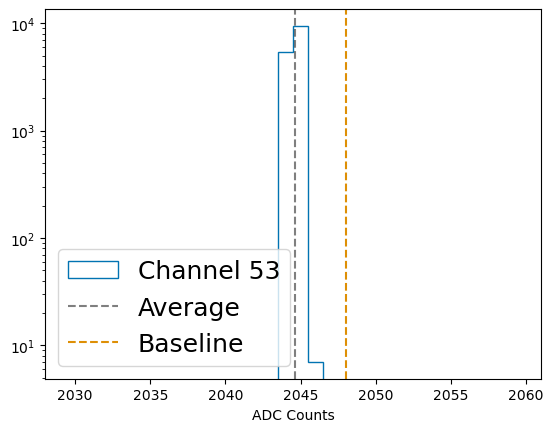

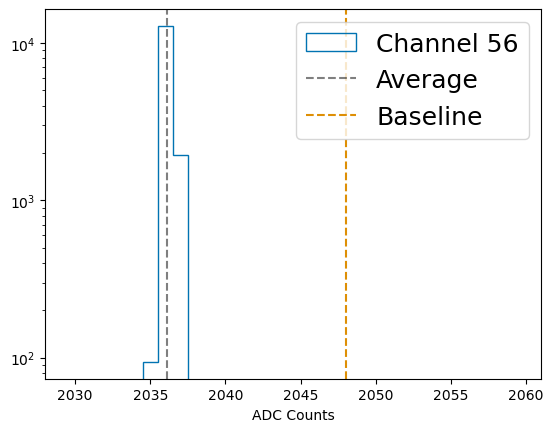

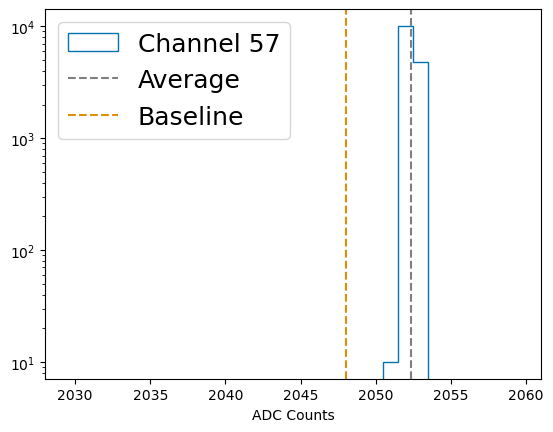

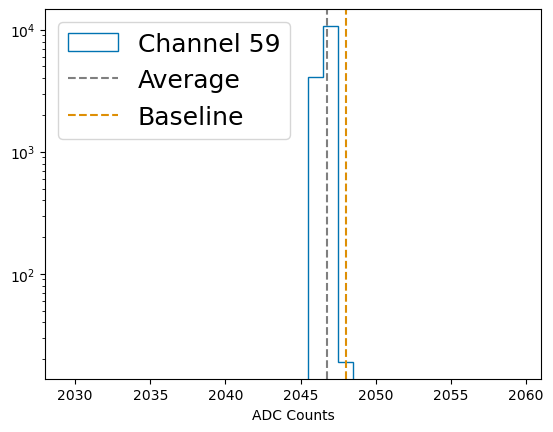

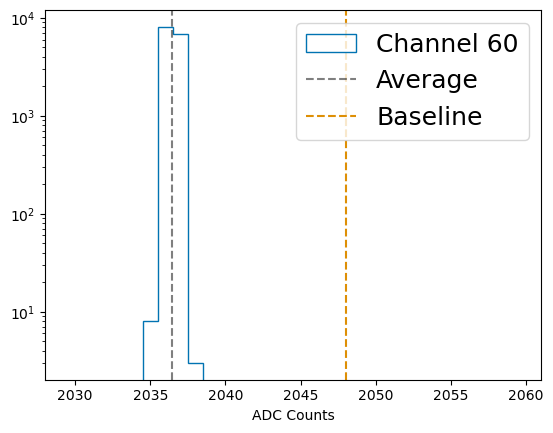

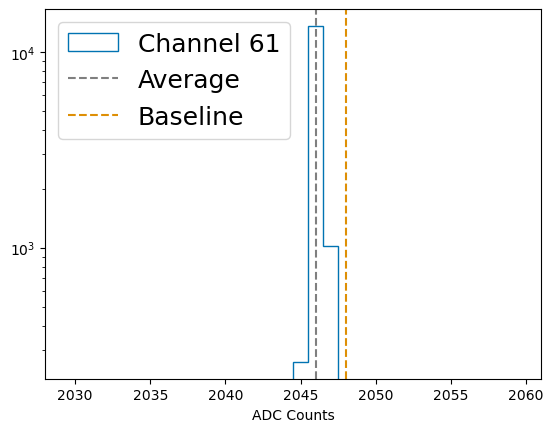

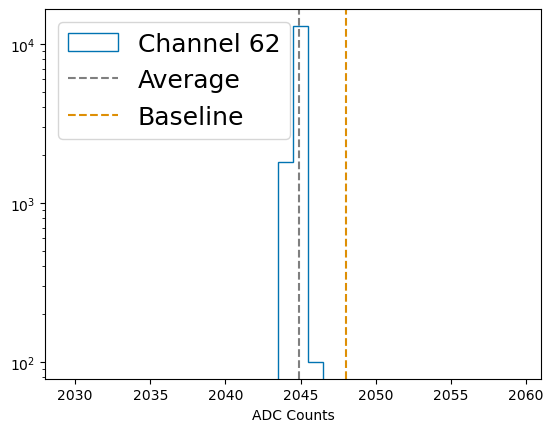

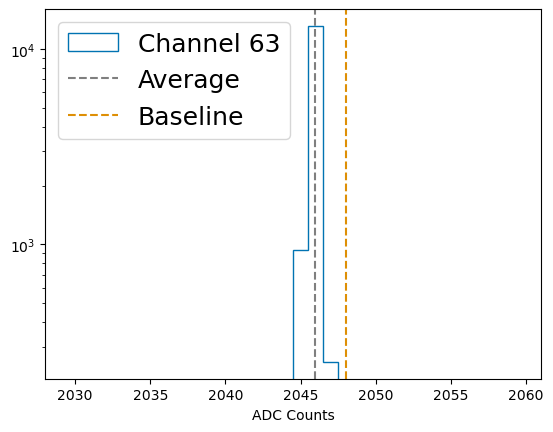

In [21]:
channels = [key for key in counts.keys()]
bins = np.linspace(2029.5, 2059.5, 31)

for channel in channels[:]:
    plt.hist(counts[channel], bins=bins, histtype='step', color=colors[0], label='Channel {}'.format(channel))
    plt.axvline(np.average(counts[channel]), color='k', ls='--', alpha=0.5, label='Average')
    plt.axvline(2048, color=colors[1], ls='--', label='Baseline')
    plt.legend(fontsize=18)
    plt.semilogy()
    plt.xlabel('ADC Counts')
    plt.show()

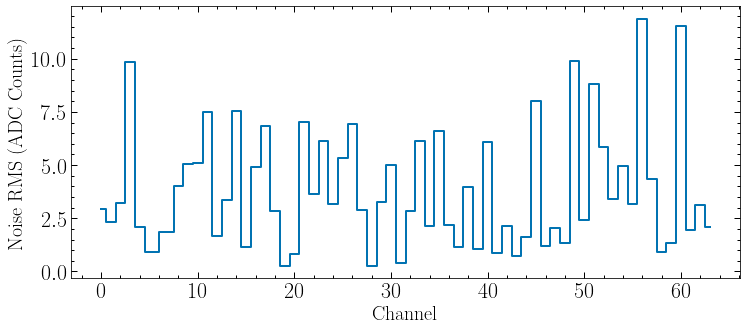

In [50]:
channels = [key for key in counts.keys()]
noise_rms = []
for ch in channels:
    mean = np.mean(counts[ch])
    squared_diffs = (counts[ch] - 2048) ** 2
    mean_squared_diff = np.mean(squared_diffs)
    noise_rms.append(np.sqrt(mean_squared_diff))
    
    
plt.figure(figsize=[12,5])
plt.step(channels, noise_rms, color=colors[0], where='mid')
plt.xlabel('Channel', fontsize=20)
plt.ylabel('Noise RMS (ADC Counts)', fontsize=20)
plt.show()

# Crosstalk

In [151]:
#Get counts for all channels

def counts_per_channel(file_list):
#inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 

    counts = dict()
    nloops = 0
    #Loop over files
    for filename in file_list:
        df = df_dict[filename]
        # find FEM ID for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # filter data by FEM and desired channel
        fem_mask = df['fem_id']==fem_id

        #get all event ids in file
        all_evs = np.unique(df['event_id'])
        
        #remove any active channel if passed
        all_chs = np.unique(df['channel_id'])[:-1]
        
        #loop over channels
        for ch in all_chs:
            counts[ch] = []
            nloops+=1
            #loop over events
            for ev in all_evs:
                mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==ev, df['channel_id']==ch))
                adc_counts = df['adc_count'][mask]
                if nloops<2:
                    nsamps = len(adc_counts)
                if(len(adc_counts)!=nsamps):
                    print('Skipping Ch: {} Event: {}. Found {} missing samples'.format(ch, ev, abs(len(adc_counts)-nsamps)))
                else:
                    counts[ch].append(adc_counts)
                    #sum_squares.append(adc_counts ** 2)
        
        channels = [key for key in counts.keys()]
        counts = {ch: np.concatenate(counts[ch]) for ch in channels}

    return channels, counts

In [152]:
channels, counts = counts_per_channel(file_list)

In [153]:
channels = sorted(counts.keys())
adc_counts = np.array([counts[ch] for ch in channels])
adc_counts = adc_counts.T
# Normalize ADC counts to zero mean and unit variance
normalized_adc_counts = (adc_counts - np.mean(adc_counts, axis=0)) / np.std(adc_counts, axis=0)
# Compute correlation matrix
correlation_matrix = np.corrcoef(normalized_adc_counts, rowvar=False)

#Compute covariance matrix
#covariance_matrix = np.cov(normalized_adc_counts, rowvar=False)

#plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
#plt.title('Cross-Talk Correlation Matrix')
#plt.xlabel('Channels')
#plt.ylabel('Channels')
#plt.show()


## Correlation of active channel with other channels

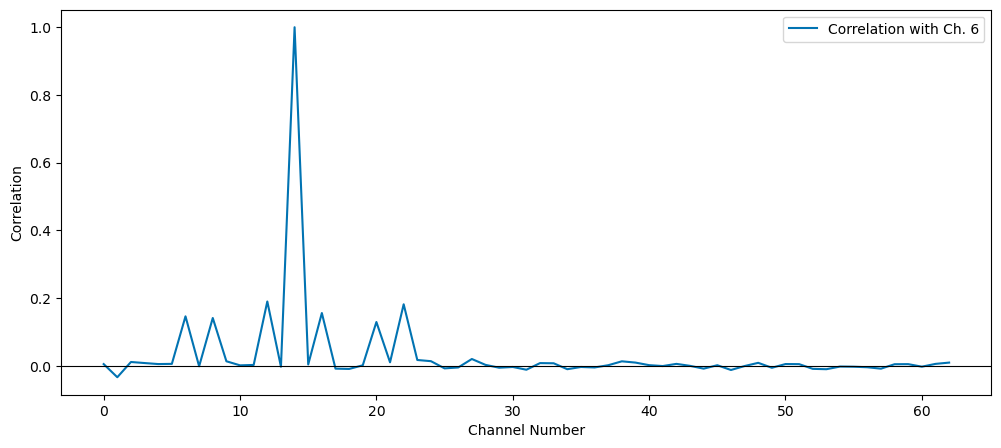

In [155]:
plt.figure(figsize=[12,5])
plt.plot(channels, correlation_matrix[14], color=colors[0], label='Correlation with Ch. {}'.format(active_ch))
plt.xlabel('Channel Number')
plt.ylabel('Correlation'.format(active_ch))
plt.axhline(0, color='black', linewidth=0.8)

plt.legend()
plt.show()

## 2D correlation matrix 

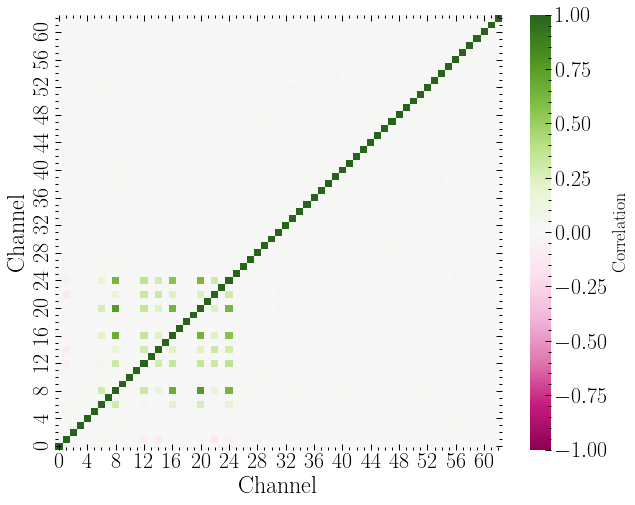

In [102]:
plt.figure(figsize=[10,8])
ax = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='PiYG', center=0, cbar_kws={'label': 'Correlation'})
ax.invert_yaxis()
ax.set_xlabel('Channel', fontsize=24)
ax.set_ylabel('Channel', fontsize=24)
plt.show()